# Simulation impot concubains avec enfants biologiques.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }<\style>"))

In [2]:
import datetime
start_time = datetime.datetime.now(); print(start_time)

2018-10-29 17:33:55.092000


In [3]:
year = 2013

In [4]:
%matplotlib inline

In [5]:
from IPython.display import display

In [6]:
import matplotlib.pyplot as plt

In [7]:
from __future__ import division
from collections import OrderedDict
import copy
import pandas as pd ; pd.set_option("display.max_columns",200)
import numpy as np
import pickle
from scipy.stats import chisquare
import statsmodels
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import statsmodels.formula.api as smf
import sys

In [8]:
import sys
sys.path.append("C:\Users\IMPTEMP_A_PACIFIC\Desktop\EDP_2015\Programme\optimisation_concubains")


In [9]:
import IRPP_from_scratch_2013 as ir


In [10]:
def load_fisc_i_by_year(year = None):
    df_fisci = pd.read_hdf(store_path, 'FISC_INDIVIDU_{}'.format(year))
    return df_fisci
def load_fisc_r_by_year(year = None):
    df_fiscr = pd.read_hdf(store_path, 'FISC_REVENU_{}'.format(year))
    return df_fiscr
def load_fisc_l_by_year(year = None):
    df_fiscr = pd.read_hdf(store_path, 'FISC_LOGEMENT_{}'.format(year))
    return df_fiscr

def load_df_fiscrevdet_by_year(year = None):
    df_fiscrevdet = pd.read_hdf(store_path, 'FISC_REVDET_{}'.format(year))
    return df_fiscrevdet
    

In [11]:
diploma_4_categories = ["No_education_femme", "Vocational_education_femme","Licence_education_femme", "Master_PhD_education_femme",
                       "No_education_homme", "Vocational_education_homme","Licence_education_homme", "Master_PhD_education_homme"]
diploma_4_categories_to_regress =  ["Vocational_education_femme","Licence_education_femme", "Master_PhD_education_femme",
                       "Vocational_education_homme","Licence_education_homme", "Master_PhD_education_homme"]

In [12]:
pd.set_option('precision', 4)
pd.set_option('display.float_format',lambda x: '%.3f' % x)

#LOAD DATASETS

In [13]:
hdf_for_exploitation_path = ("C:\Users\IMPTEMP_A_PACIFIC\Desktop\EDP_2015\Programme\optimisation_concubains\Re_restart_from_scratch\\"
            + "Generated_hdf\data_to_exploit.h5")

In [14]:
%%time
for key in ["df2013_A","df2013_B", "df2013_C", "df2013_D",
            "df2014_A","df2014_B", "df2014_C","df2014_D", 
            "df_concat_A", "df_concat_B","df_concat_C","df_concat_D",
            "df_A", "df_B", "df_C", "df_D"]:
    globals()[key] = pd.read_hdf(hdf_for_exploitation_path, key)

Wall time: 2.73 s


In [15]:
irpp_decote_allocation_list = ["Irpp_decote_allocation_{}".format(alloc_nb) for alloc_nb in range(1,9)]

# Create diplomas datasets

In [16]:
diploma_4_categories_2013 = [a + "_2013" for a in diploma_4_categories]
for key in ["df2013_A","df2013_B", "df2013_C", "df2013_D",
            "df2014_A","df2014_B", "df2014_C","df2014_D", 
            "df_concat_A", "df_concat_B","df_concat_C","df_concat_D",
            "df_A", "df_B", "df_C", "df_D"]:
    

    
    
    
    df_temp = globals()[key]
    try:
        df_temp = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2] #Keep households for which we have parents diplomas for both years.
        globals()[key+"_diplomas"] = df_temp
    except KeyError: #Deal with diplomas variable having the year in the end of the name
        try: 
            df_temp = df_temp[df_temp[diploma_4_categories_2013].sum(axis = 1) == 2]
            globals()[key+"_diplomas"] = df_temp
        except: Boum

    

In [17]:
df2013_A.shape

(51190, 227)

In [18]:
df2013_A_diplomas.shape

(32292, 227)

#### Enfant dans l'année

In [19]:
new_child_2014_id_fisc_log = df_A[df_A.Family_child_gain].ID_FISC_LOG_DIFF
df_A_new_child = df_A[df_A.Family_child_gain]
df_temp = df_temp[df_temp.ID_FISC_LOG_DIFF.isin(new_child_2014_id_fisc_log)]

### Descriptive stats descriptive stat

In [20]:
df2013_A["Ecart_age_pere_mere"] = df2013_A.Age_pere - df2013_A.Age_mere
df2013_A["Ecart_income_pere_mere"] = np.abs(df2013_A.Rni_pere - df2013_A.Rni_mere)

In [21]:
df2013_A[["Rni","Ecart_income_pere_mere", "Age_moyen","Ecart_age_pere_mere", "Ecart_Age_en_valeur_absolue", "Nb_enfants"]].mean()

Rni                           35405.749
Ecart_income_pere_mere        10131.669
Age_moyen                        33.880
Ecart_age_pere_mere               2.267
Ecart_Age_en_valeur_absolue       3.483
Nb_enfants                        1.560
dtype: float64

In [22]:
df2013_A_diplomas.shape

(32292, 227)

In [23]:
for child in range(1,7):
    df2013_A["Children_number_is_{}".format(child)] = df2013_A.Nb_enfants == child ; df2013_A["Children_number_is_4_and_more"] = df2013_A.Nb_enfants >= 4
    df2013_B["Children_number_is_{}".format(child)] = df2013_A.Nb_enfants == child ; df2013_B["Children_number_is_4_and_more"] = df2013_B.Nb_enfants >= 4
children_number_list = ["Children_number_is_{}".format(child) for child in range(1,4)]+["Children_number_is_4_and_more"]

In [24]:
children_number_list


['Children_number_is_1',
 'Children_number_is_2',
 'Children_number_is_3',
 'Children_number_is_4_and_more']

In [25]:
df2013_A.query("Nb_enfants==1").Age_elder_child.mean()
df2013_A.query("Nb_enfants==1").Age_younger_child.mean()

3.0300190364621469

In [26]:
for df_temp in [df2013_A,df2013_B]:
    for child in range(1,7):
        condition_1 = (df_temp.Nb_enfants == child)
        condition_2 = (df_temp.Nb_enfants >= 4)
        df_temp.loc[condition_1,"Children_number_is_{}_Mean_Age_children".format(child)] = df_temp.Age_moyen_children
        df_temp.loc[condition_1,"Children_number_is_{}_Age_elder_child".format(child)] = df_temp.Age_elder_child
        df_temp.loc[condition_1,"Children_number_is_{}_Age_younger_child".format(child)] = df_temp.Age_younger_child
        df_temp.loc[condition_2,"Children_number_is_4_and_more_Mean_Age_children".format(child)] = df_temp.Age_moyen_children
        df_temp.loc[condition_2,"Children_number_is_4_and_more_Age_elder_child".format(child)] = df_temp.Age_elder_child
        df_temp.loc[condition_2,"Children_number_is_4_and_more_Age_younger_child".format(child)] = df_temp.Age_younger_child

children_var_list = ["Children_number_is_{}".format(child)+var for child in range(1,4)for var in ["","_Mean_Age_children", "_Age_elder_child", "_Age_younger_child"]]
children_var_list += ["Children_number_is_4_and_more"+var for var in ["","_Mean_Age_children", "_Age_elder_child", "_Age_younger_child"]]
children_var_list

['Children_number_is_1',
 'Children_number_is_1_Mean_Age_children',
 'Children_number_is_1_Age_elder_child',
 'Children_number_is_1_Age_younger_child',
 'Children_number_is_2',
 'Children_number_is_2_Mean_Age_children',
 'Children_number_is_2_Age_elder_child',
 'Children_number_is_2_Age_younger_child',
 'Children_number_is_3',
 'Children_number_is_3_Mean_Age_children',
 'Children_number_is_3_Age_elder_child',
 'Children_number_is_3_Age_younger_child',
 'Children_number_is_4_and_more',
 'Children_number_is_4_and_more_Mean_Age_children',
 'Children_number_is_4_and_more_Age_elder_child',
 'Children_number_is_4_and_more_Age_younger_child']

In [27]:
df2013_A.query("Nb_enfants==1").Children_number_is_1_Mean_Age_children.mean()

3.0300190364621469

In [28]:
var_list = ["Rni","Rni_mere", "Rni_pere","Diff_in_incompe_mere_pere", "Age_moyen_parents","Age_pere", "Age_mere", "Ecart_Age_en_valeur_absolue", "Nb_enfants","Age_moyen_children", "Age_elder_child", "Age_younger_child"
           ]+ children_var_list +["TC"]

#["Rni","Rni_pere", "Rni_mere" ,"Diff_in_incompe_mere_pere", "Age_moyen_parents","Age_pere", "Age_mere", "Age_moyen_children", "Age_elder_child", "Age_younger_child"]

In [29]:
var_list[-2]

'Children_number_is_4_and_more_Age_younger_child'

In [30]:
mean_age_by_child_number = [x + "_X_mean_age" for x in children_number_list]

In [31]:
"Children_number_is_1"[19]

'1'

In [32]:
children_var_list[13]

'Children_number_is_4_and_more_Mean_Age_children'

In [33]:
def make_descriptive_with_diplomas_table_two_years(df, var_list, cond_not_optm_str = None, diplomas = True, full = False): 
    good_colomun_order = list()
    df_dict = dict()
    df_temp = df
    vars_list = copy.copy(var_list) #["Rni","Rni_mere", "Rni_pere","Diff_in_incompe_mere_pere", "Age_moyen", "Ecart_Age_en_valeur_absolue", "Nb_enfants", "Age_elder_child", "Age_younger_child"]


 
    cond_diploma = df_temp[diploma_4_categories].sum(axis = 1) == 2


#     do_not_optimize_list = list()
#     optimize_list = list()
    all_list = list()
    diploma_list = list()
    compare_means_list = list()
    cond_not_optm = df_temp[cond_not_optm_str]

    for var in vars_list:
        if var in [children_var_list[i] for i in [1,2,3,5,6,7,9,10,11,13,14,15]]:
            sub_value_child = float(var[19])
            try :
                    
                if sub_value_child ==4: all_list.append(df_temp.query("Nb_enfants>={}".format(sub_value_child))[var].mean())
                else: all_list.append(df_temp.query("Nb_enfants=={}".format(sub_value_child))[var].mean())
                    
            except KeyError:
                all_list.append(0)
        else:
            try : 
                all_list.append(df_temp[var].mean())
            except KeyError:
                all_list.append(0)
    
                    
    for var in vars_list+diploma_4_categories:
        if var in [children_var_list[i] for i in [1,2,3,5,6,7,9,10,11,13,14,15]]:
            sub_value_child = float(var[19])
            try :
                    
                if sub_value_child ==4: diploma_list.append(df_temp[cond_diploma].query("Nb_enfants>={}".format(sub_value_child))[var].mean())
                else: diploma_list.append(df_temp[cond_diploma].query("Nb_enfants=={}".format(sub_value_child))[var].mean())
                    
            except KeyError:
                diploma_list.append(0)
        else:
            try : 
                diploma_list.append(df_temp[cond_diploma][var].mean())
            except KeyError:
                diploma_list.append(0)
            
    
    ## T-tests
    for var in vars_list:
        try :
            if var in [children_var_list[i] for i in [1,2,3,5,6,7,9,10,11,13,14,15]]:
                
                sub_value_child = var[19]
                if float(sub_value_child) < 4:
                    weight_stat_diploma =   statsmodels.stats.weightstats.DescrStatsW(df_temp[cond_diploma].query("Nb_enfants=={}".format(sub_value_child))[var])
                    weight_stat_des_all =   statsmodels.stats.weightstats.DescrStatsW(df_temp.query("Nb_enfants=={}".format(sub_value_child))[var])
                else:
                    weight_stat_diploma =   statsmodels.stats.weightstats.DescrStatsW(df_temp[cond_diploma].query("Nb_enfants>={}".format(sub_value_child))[var])
                    weight_stat_des_all =   statsmodels.stats.weightstats.DescrStatsW(df_temp.query("Nb_enfants>={}".format(sub_value_child))[var])
                    
                
                t_test = statsmodels.stats.weightstats.CompareMeans(weight_stat_des_all,weight_stat_diploma).ttest_ind()
                compare_means_list.append(t_test)
                #if var == "Children_number_is_1_Age_younger_child":BOUM
                
            
            else:
                weight_stat_diploma =   statsmodels.stats.weightstats.DescrStatsW(df_temp[cond_diploma][var])
                weight_stat_des_all =   statsmodels.stats.weightstats.DescrStatsW(df_temp[var])
                t_test = statsmodels.stats.weightstats.CompareMeans(weight_stat_des_all,weight_stat_diploma).ttest_ind()
                compare_means_list.append(t_test)
        except KeyError:
            compare_means_list.append(0)
    compare_means_list_transformed = [[a[i] for a in compare_means_list] for i in range(len(compare_means_list[0]))]
    #return len(diploma_list)
    df = pd.DataFrame({"All": all_list+[0]*8 ,"Diplomas_sample": diploma_list,
                      'Delta':pd.Series(all_list+[np.NAN]*8) -pd.Series(diploma_list) , "t-test":compare_means_list_transformed[0]+[np.NAN]*8,  "p-value":compare_means_list_transformed[1]+[np.NAN]*8,  })#"Not_opt_2014" :do_not_optimize_2014_list
    df.index = vars_list+diploma_4_categories
    df.loc["N_obs", "All"] = df_temp.shape[0]   
    df.loc["N_obs", "Diplomas_sample"] = df_temp[cond_diploma].shape[0]



    return df[["All", "Diplomas_sample","Delta",  "t-test" ,  "p-value" ]].fillna("")

In [34]:
df2013_A.query("Nb_enfants==1").Age_younger_child.mean()

3.0300190364621469

In [35]:
make_descriptive_with_diplomas_table_two_years(df2013_A,var_list,
                       "Do_not_optimize",diplomas = True )

,All,Diplomas_sample,Delta,t-test,p-value
Rni,35405.749,35439.382,-33.633,-0.201,0.841
Rni_mere,14816.468,14787.088,29.380,0.329,0.742
Rni_pere,20589.280,20652.294,-63.013,-0.514,0.607
Diff_in_incompe_mere_pere,10131.669,9860.822,270.847,2.247,0.025
Age_moyen_parents,33.880,34.162,-0.282,-6.300,0.000
Age_pere,35.014,35.277,-0.263,-5.339,0.000
Age_mere,32.746,33.047,-0.301,-6.683,0.000
Ecart_Age_en_valeur_absolue,3.483,3.411,0.072,3.090,0.002
Nb_enfants,1.560,1.580,-0.020,-3.909,0.000
Age_moyen_children,3.747,3.981,-0.234,-10.251,0.000


In [36]:
def make_descriptive_with_diplomas_table_two_years(df_concat, var_list, cond_not_optm_str = None, diplomas = True, full = False): 
    good_colomun_order = list()
    for year in [2013,2014]:
        for col in ["All_{}".format(year),  "opt_{}".format(year), "Not_opt_{}".format(year), "Delta_{}".format(year) ]:
            good_colomun_order.append(col)
    df_dict = dict()
    df_temp = df_concat
    vars_list = copy.copy(var_list) #["Rni","Rni_mere", "Rni_pere","Diff_in_incompe_mere_pere", "Age_moyen", "Ecart_Age_en_valeur_absolue", "Nb_enfants", "Age_elder_child", "Age_younger_child"]

    if diplomas == True:
        vars_list += diploma_4_categories 
        df_temp = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]



    do_not_optimize_list = list()
    optimize_list = list()
    all_list = list()
    compare_means_list = list()
    cond_not_optm = df_temp[cond_not_optm_str]

    for var in vars_list:
        try : 
            all_list.append(df_temp[var].mean())
        except KeyError:
            all_list.append(0)
        try : 
            do_not_optimize_list.append(df_temp[cond_not_optm][var].mean())
        except KeyError:
            do_not_optimize_list.append(0)
        try : 
            optimize_list.append(df_temp[~cond_not_optm][var].mean())
        except KeyError:
            optimize_list.append(0)
    
    
    for var in vars_list:
        try : 
            weight_stat_des_opt =   statsmodels.stats.weightstats.DescrStatsW(df_temp[~cond_not_optm][var])
            weight_stat_des_not_opt =   statsmodels.stats.weightstats.DescrStatsW(df_temp[cond_not_optm][var])
            t_test = statsmodels.stats.weightstats.CompareMeans(weight_stat_des_opt,weight_stat_des_not_opt).ttest_ind()
            compare_means_list.append(t_test)
        except KeyError:
            compare_means_list.append(0)
    compare_means_list_transformed = [[a[i] for a in compare_means_list] for i in range(len(compare_means_list[0]))]

    df = pd.DataFrame({"All": all_list ,"opt" :optimize_list,"Not_opt" :do_not_optimize_list ,
                      'Delta':pd.Series(optimize_list) -pd.Series(do_not_optimize_list) , "t-test":compare_means_list_transformed[0],  "p-value":compare_means_list_transformed[1],  })#"Not_opt_2014" :do_not_optimize_2014_list
    df.index = vars_list
    df.loc["N_obs", "All"] = df_temp.shape[0]   
    df.loc["N_obs", "opt".format(year)] = df_temp[~cond_not_optm].shape[0]
    df.loc["N_obs", "Not_opt".format(year)] = df_temp[cond_not_optm].shape[0]


    return df[["All","opt","Not_opt", "Delta",  "t-test" ,  "p-value" ]].fillna("")
    #return df[["All","opt","Not_opt", "Delta"  ]]#[[ "Share","N","Share_2014","N_2014"]]

In [37]:
var_list

['Rni',
 'Rni_mere',
 'Rni_pere',
 'Diff_in_incompe_mere_pere',
 'Age_moyen_parents',
 'Age_pere',
 'Age_mere',
 'Ecart_Age_en_valeur_absolue',
 'Nb_enfants',
 'Age_moyen_children',
 'Age_elder_child',
 'Age_younger_child',
 'Children_number_is_1',
 'Children_number_is_1_Mean_Age_children',
 'Children_number_is_1_Age_elder_child',
 'Children_number_is_1_Age_younger_child',
 'Children_number_is_2',
 'Children_number_is_2_Mean_Age_children',
 'Children_number_is_2_Age_elder_child',
 'Children_number_is_2_Age_younger_child',
 'Children_number_is_3',
 'Children_number_is_3_Mean_Age_children',
 'Children_number_is_3_Age_elder_child',
 'Children_number_is_3_Age_younger_child',
 'Children_number_is_4_and_more',
 'Children_number_is_4_and_more_Mean_Age_children',
 'Children_number_is_4_and_more_Age_elder_child',
 'Children_number_is_4_and_more_Age_younger_child',
 'TC']

## Optimize vs. Do not optimize

### With diplomas

In [38]:
make_descriptive_with_diplomas_table_two_years(df2013_A,var_list,
                       "Do_not_optimize",diplomas = True )

,All,opt,Not_opt,Delta,t-test,p-value
Rni,35439.382,34411.899,38449.314,-4037.414,-16.499,0.000
Rni_mere,14787.088,13912.144,17350.170,-3438.026,-24.539,0.000
Rni_pere,20652.294,20499.755,21099.143,-599.388,-3.615,0.000
Diff_in_incompe_mere_pere,9860.822,10774.857,7183.228,3591.629,23.204,0.000
Age_moyen_parents,34.162,33.940,34.811,-0.871,-11.050,0.000
Age_pere,35.277,35.077,35.860,-0.783,-9.010,0.000
Age_mere,33.047,32.803,33.763,-0.960,-12.108,0.000
Ecart_Age_en_valeur_absolue,3.411,3.433,3.345,0.088,2.123,0.034
Nb_enfants,1.580,1.570,1.609,-0.039,-4.387,0.000
Age_moyen_children,3.981,3.933,4.123,-0.191,-4.651,0.000


#### Optimize at 1%

In [39]:
make_descriptive_with_diplomas_table_two_years(df2013_A,var_list,
                       "Do_not_optimize_1_prct_income_share",diplomas = True )

,All,opt,Not_opt,Delta,t-test,p-value
Rni,35439.382,35469.873,35095.634,374.239,0.956,0.339
Rni_mere,14787.088,14832.831,14271.395,561.436,2.494,0.013
Rni_pere,20652.294,20637.042,20824.239,-187.197,-0.709,0.478
Diff_in_incompe_mere_pere,9860.822,9797.778,10571.556,-773.778,-3.114,0.002
Age_moyen_parents,34.162,34.145,34.352,-0.207,-1.647,0.100
Age_pere,35.277,35.257,35.499,-0.242,-1.749,0.080
Age_mere,33.047,33.033,33.205,-0.172,-1.360,0.174
Ecart_Age_en_valeur_absolue,3.411,3.406,3.458,-0.051,-0.778,0.436
Nb_enfants,1.580,1.561,1.797,-0.236,-16.838,0.000
Age_moyen_children,3.981,3.986,3.926,0.061,0.928,0.353


### Without diplomas

In [40]:
make_descriptive_with_diplomas_table_two_years(df2013_A,var_list,
                       "Do_not_optimize",diplomas = False )

,All,opt,Not_opt,Delta,t-test,p-value
Rni,35405.749,34402.458,38445.475,-4043.016,-15.253,0.000
Rni_mere,14816.468,14029.287,17201.435,-3172.148,-23.185,0.000
Rni_pere,20589.280,20373.171,21244.039,-870.868,-4.375,0.000
Diff_in_incompe_mere_pere,10131.669,10956.914,7631.377,3325.537,16.825,0.000
Age_moyen_parents,33.880,33.625,34.651,-1.026,-15.767,0.000
Age_pere,35.014,34.776,35.733,-0.957,-13.379,0.000
Age_mere,32.746,32.475,33.569,-1.094,-16.704,0.000
Ecart_Age_en_valeur_absolue,3.483,3.500,3.430,0.071,2.071,0.038
Nb_enfants,1.560,1.546,1.604,-0.058,-8.009,0.000
Age_moyen_children,3.747,3.694,3.909,-0.215,-6.545,0.000


In [41]:
make_descriptive_with_diplomas_table_two_years(df2013_A,var_list,
                       "Do_not_optimize_1_prct_income_share",diplomas = False )

,All,opt,Not_opt,Delta,t-test,p-value
Rni,35405.749,35427.817,35160.182,267.636,0.642,0.521
Rni_mere,14816.468,14897.286,13917.176,980.110,4.539,0.000
Rni_pere,20589.280,20530.532,21243.006,-712.474,-2.279,0.023
Diff_in_incompe_mere_pere,10131.669,10021.563,11356.863,-1335.299,-4.291,0.000
Age_moyen_parents,33.880,33.848,34.238,-0.390,-3.807,0.000
Age_pere,35.014,34.977,35.423,-0.446,-3.962,0.000
Age_mere,32.746,32.719,33.052,-0.334,-3.237,0.001
Ecart_Age_en_valeur_absolue,3.483,3.475,3.568,-0.093,-1.737,0.082
Nb_enfants,1.560,1.540,1.781,-0.240,-21.205,0.000
Age_moyen_children,3.747,3.745,3.772,-0.027,-0.524,0.600


##### Child birth in 2013

In [42]:
make_descriptive_with_diplomas_table_two_years(df2013_A[df2013_A.ID_FISC_LOG_DIFF.isin(new_child_2014_id_fisc_log)], var_list,
                       "Do_not_optimize_1_prct_income_share",diplomas = True )

,All,opt,Not_opt,Delta,t-test,p-value
Rni,33527.105,33632.164,32229.006,1403.158,0.863,0.388
Rni_mere,14170.329,14201.199,13788.902,412.297,0.553,0.580
Rni_pere,19356.776,19430.965,18440.104,990.861,0.788,0.431
Diff_in_incompe_mere_pere,8637.528,8648.449,8502.589,145.860,0.127,0.899
Age_moyen_parents,31.445,31.443,31.469,-0.026,-0.071,0.943
Age_pere,32.589,32.600,32.448,0.152,0.357,0.721
Age_mere,30.301,30.286,30.491,-0.205,-0.551,0.582
Ecart_Age_en_valeur_absolue,3.182,3.172,3.307,-0.135,-0.558,0.577
Nb_enfants,1.247,1.235,1.387,-0.151,-3.635,0.000
Age_moyen_children,3.038,3.036,3.060,-0.024,-0.150,0.881


In [43]:
import statsmodels.stats.weightstats as lo

In [44]:
sm.stats.ttest_ind(df2013_D[df2013_D.Do_not_optimize].Age_moyen,df2013_D[~df2013_D.Do_not_optimize].Age_moyen )

(11.85548751715522, 2.2671254578719701e-32, 42478.0)

In [45]:
var_list = ["Rni","Rni_pere", "Rni_mere" ,"Diff_in_incompe_mere_pere", "Age_moyen_parents","Age_pere", "Age_mere", "Age_moyen_children", "Age_elder_child", "Age_younger_child"]

In [46]:
pd.options.display.float_format = '{:.2f}'.format

#### By number of children

In [47]:
df_temp = pd.DataFrame()

for var in var_list+diploma_4_categories:
        df_temp.loc[var, "All"] = df2013_A_diplomas[var].mean()
df_temp.loc["N_Obs", "All"] = len(df2013_A_diplomas)
df_temp.loc["Share", "All"] = len(df2013_A_diplomas) / len(df2013_A_diplomas)
for var in var_list+diploma_4_categories:
    for child in range(1,7):
        df_temp.loc[var, child] = df2013_A_diplomas.query("Nb_enfants == {}".format(child))[var].mean()
        df_temp.loc["N_Obs", child] = len(df2013_A_diplomas.query("Nb_enfants == {}".format(child)))
        df_temp.loc["Share", child] = len(df2013_A_diplomas.query("Nb_enfants == {}".format(child))) / len(df2013_A_diplomas)
df_mean_diplomas = df_temp

In [48]:
df_mean_diplomas

,All,1,2,3,4,5,6
Rni,35439.38,35878.57,35965.82,30056.66,26326.17,27902.44,18870.28
Rni_pere,20652.29,20192.64,21418.28,20253.42,17032.77,20635.56,14649.15
Rni_mere,14787.09,15685.93,14547.54,9803.24,9293.40,7266.89,4221.13
Diff_in_incompe_mere_pere,9860.82,8690.38,10724.91,13816.49,11734.43,15679.78,11877.11
Age_moyen_parents,34.16,33.43,34.93,35.34,33.73,35.53,33.29
Age_pere,35.28,34.52,36.03,36.68,35.18,36.89,34.57
Age_mere,33.05,32.34,33.82,34.01,32.28,34.17,32.02
Age_moyen_children,3.98,3.27,4.63,5.55,4.38,5.87,4.57
Age_elder_child,4.80,3.27,6.16,8.35,6.44,9.72,7.28
Age_younger_child,3.15,3.27,3.11,2.53,2.28,1.67,1.66


In [49]:
df_temp = pd.DataFrame()

for var in var_list:
        df_temp.loc[var, "All"] = df2013_A[var].mean()
df_temp.loc["N_Obs", "All"] = len(df2013_A)
df_temp.loc["Share", "All"] = len(df2013_A) / len(df2013_A)
for var in var_list:
    for child in range(1,7):
        df_temp.loc[var, child] = df2013_A.query("Nb_enfants == {}".format(child))[var].mean()
        df_temp.loc["N_Obs", child] = len(df2013_A.query("Nb_enfants == {}".format(child)))
        df_temp.loc["Share", child] = len(df2013_A.query("Nb_enfants == {}".format(child))) / len(df2013_A)
df_mean =df_temp; df_mean.index.name = "Nb_child"; df_mean

,All,1,2,3,4,5,6
Nb_child,,,,,,,
Rni,35405.75,35948.78,35932.26,29574.37,25333.01,21569.05,19223.62
Rni_pere,20589.28,20245.24,21357.15,19873.44,16514.78,15555.39,14972.87
Rni_mere,14816.47,15703.54,14575.11,9700.93,8818.22,6013.66,4250.75
Diff_in_incompe_mere_pere,10131.67,9130.51,11002.31,13532.97,11361.01,12046.37,12106.21
Age_moyen_parents,33.88,33.11,34.75,35.23,33.75,35.02,34.21
Age_pere,35.01,34.22,35.87,36.59,35.25,36.59,35.92
Age_mere,32.75,32.00,33.63,33.87,32.26,33.46,32.49
Age_moyen_children,3.75,3.03,4.47,5.42,4.30,5.99,4.83
Age_elder_child,4.50,3.03,5.92,8.18,6.35,9.76,7.66


In [50]:
###Stats 4 child or more

In [51]:
df2013_A.query("Nb_enfants >= 4")[["Age_moyen_children", "Age_elder_child", "Age_younger_child"]].mean()

Age_moyen_children   4.43
Age_elder_child      6.63
Age_younger_child    2.15
dtype: float64

In [52]:
 df2013_A_diplomas.query("Nb_enfants >= 4")[["Age_moyen_children", "Age_elder_child", "Age_younger_child"]].mean()

Age_moyen_children   4.44
Age_elder_child      6.62
Age_younger_child    2.21
dtype: float64

In [53]:
df_mean - df_mean_diplomas

,All,1,2,3,4,5,6
Age_elder_child,-0.30,-0.24,-0.23,-0.18,-0.09,0.03,0.38
Age_mere,-0.30,-0.34,-0.19,-0.14,-0.02,-0.70,0.47
Age_moyen_children,-0.23,-0.24,-0.16,-0.13,-0.08,0.12,0.27
Age_moyen_parents,-0.28,-0.32,-0.18,-0.12,0.03,-0.50,0.92
Age_pere,-0.26,-0.30,-0.16,-0.09,0.07,-0.30,1.36
Age_younger_child,-0.16,-0.24,-0.09,-0.07,-0.05,-0.03,0.13
Diff_in_incompe_mere_pere,270.85,440.13,277.41,-283.52,-373.42,-3633.41,229.09
Licence_education_femme,nan,nan,nan,nan,nan,nan,nan
Licence_education_homme,nan,nan,nan,nan,nan,nan,nan
Master_PhD_education_femme,nan,nan,nan,nan,nan,nan,nan


# Repartition between man and woman

### Effective repartition

In [54]:
assert np.all((df2013_A.Allocation_mere + df2013_A.Allocation_pere) == df2013_A.Nb_enfants)

In [55]:
df2013_A["All_on_man"] = df2013_A.Allocation_pere == df2013_A.Nb_enfants
df2013_A["All_on_woman"] = df2013_A.Allocation_mere == df2013_A.Nb_enfants

In [56]:
df2013_A["Equal_split"] = df2013_A.Allocation_pere == df2013_A.Allocation_mere

In [57]:
df2013_A["Most_on_man"] = (~df2013_A.All_on_man)& (df2013_A.Allocation_pere > df2013_A.Allocation_mere)
df2013_A["Most_on_woman"] = (~df2013_A.All_on_woman)& (df2013_A.Allocation_pere < df2013_A.Allocation_mere)

In [58]:
df2013_A[["All_on_man","All_on_woman","Equal_split", "Most_on_man",  "Most_on_woman" ]].mean()

All_on_man      0.52
All_on_woman    0.30
Equal_split     0.17
Most_on_man     0.01
Most_on_woman   0.01
dtype: float64

In [59]:
df_child_repartition = pd.DataFrame()
for child in range(1,7):
    df_temp = df2013_A.query("Nb_enfants == {}".format(child))[["All_on_man","All_on_woman","Equal_split", "Most_on_man",  "Most_on_woman" ]]
    df_child_repartition["child_{}".format(child)] = df_temp.mean()

In [60]:
n_obs_by_child_rank_array =[len( df2013_A.query("Nb_enfants == {}".format(child))) for child in range(1,7)]

In [61]:
#Effective repartition
df_child_repartition["Total_average"] = df2013_A[["All_on_man","All_on_woman","Equal_split", "Most_on_man",  "Most_on_woman" ]].mean()
df_child_repartition.loc["N_obs", :] = n_obs_by_child_rank_array + [""]
df_child_repartition

,child_1,child_2,child_3,child_4,child_5,child_6,Total_average
All_on_man,0.59,0.44,0.58,0.14,0.54,0.06,0.52
All_on_woman,0.41,0.18,0.13,0.03,0.10,0.01,0.30
Equal_split,0.00,0.39,0.00,0.80,0.00,0.91,0.17
Most_on_man,0.00,0.00,0.18,0.03,0.22,0.03,0.01
Most_on_woman,0.00,0.00,0.11,0.01,0.15,0.00,0.01
N_obs,27316.00,20411.00,2399.00,909.00,41.00,106.00,


In [62]:
#Effective repartition
df_child_repartition["Total_average"] = df2013_A[["All_on_man","All_on_woman","Equal_split", "Most_on_man",  "Most_on_woman" ]].mean()
df_child_repartition.loc["N_obs", :] = n_obs_by_child_rank_array + [""]
df_child_repartition

,child_1,child_2,child_3,child_4,child_5,child_6,Total_average
All_on_man,0.59,0.44,0.58,0.14,0.54,0.06,0.52
All_on_woman,0.41,0.18,0.13,0.03,0.10,0.01,0.30
Equal_split,0.00,0.39,0.00,0.80,0.00,0.91,0.17
Most_on_man,0.00,0.00,0.18,0.03,0.22,0.03,0.01
Most_on_woman,0.00,0.00,0.11,0.01,0.15,0.00,0.01
N_obs,27316.00,20411.00,2399.00,909.00,41.00,106.00,


In [63]:
cm = statsmodels.stats.weightstats.CompareMeans(statsmodels.stats.weightstats.DescrStatsW(df2013_A[["Age_pere", "Age_mere"]]),statsmodels.stats.weightstats.DescrStatsW(df2013_A[["Age_pere", "Age_mere"]]+0.1))

In [64]:
statsmodels.stats.weightstats.DescrStatsW([1,2,3])

In [65]:
cm.std_meandiff_separatevar

array([ 0.04378071,  0.04011741])

In [66]:
a = df2013_A.Optimal_allocations.str.split("allocation_").apply(set)

In [67]:
df2013_A["Optimal_allocation_number"] = df2013_A.Optimal_allocations.str.split("allocation_").apply(lambda x: x[1:])


### Optimal repartition

In [68]:
def list_string_to_int(liste):
    return [int(b) for b in liste ]

df2013_A["Optimal_allocation_number"] = df2013_A.Optimal_allocation_number.apply(lambda x: list_string_to_int(x))

In [69]:
df2013_A["Optimal_allocation_number_minus_one"] = df2013_A.Optimal_allocation_number.apply(lambda x: [a-1 for a in x])

In [70]:
( df2013_A.apply(lambda x: x["Nb_enfants"]+1 in x["Optimal_allocation_number"], 1)).value_counts()

True     33643
False    17547
dtype: int64

In [71]:
df2013_A["Most_on_man"].value_counts()

False    50722
True       468
dtype: int64

In [72]:
df2013_A["All_on_man_optimal"] = ( df2013_A.apply(lambda x: x["Nb_enfants"]+1 in x["Optimal_allocation_number"], 1)) #Since the last allocation (nb_enf+1) is the allocation where all children are on the father
df2013_A["All_on_woman_optimal"] = ( df2013_A.apply(lambda x: 1 in x["Optimal_allocation_number"], 1)) #Since the first allocation is the allocation where all children are on the father


df2013_A["Equal_split_optimal"] =   (df2013_A.apply(lambda x: (x["Nb_enfants"]/2) in x["Optimal_allocation_number_minus_one"], 1)) #Since the middle allocation is the equalt split allocation.


df2013_A["Most_on_man_optimal"] =  ((df2013_A.apply(
            lambda x: [a> ((x["Nb_enfants"]/2)) for a in  x["Optimal_allocation_number_minus_one"]], 1)).apply(any)  #Since the allocations greater than the middle allocations are those of the father
                                    & (~df2013_A["All_on_man_optimal"]) )
df2013_A["Most_on_woman_optimal"] =  ((df2013_A.apply(
            lambda x: [a< ((x["Nb_enfants"]/2)) for a in  x["Optimal_allocation_number_minus_one"]], 1)).apply(any)  #Since the allocations greater than the middle allocations are those of the mother
                                      & (~ df2013_A["All_on_woman_optimal"]))

In [73]:
df_child_repartition = pd.DataFrame()
for child in range(1,7):
    df_temp = df2013_A.query("Nb_enfants == {}".format(child))[["All_on_man_optimal","All_on_woman_optimal","Equal_split_optimal", "Most_on_man_optimal",  "Most_on_woman_optimal" ]]
    df_child_repartition["child_{}".format(child)] = df_temp.mean()
    

In [74]:
df_child_repartition.loc["Total"] = df_child_repartition.sum(axis = 0)
df_child_repartition.loc["N_obs"] = n_obs_by_child_rank_array ; df_child_repartition

,child_1,child_2,child_3,child_4,child_5,child_6
All_on_man_optimal,0.70,0.59,0.74,0.70,0.83,0.86
All_on_woman_optimal,0.41,0.22,0.22,0.33,0.39,0.36
Equal_split_optimal,0.00,0.48,0.00,0.61,0.00,0.89
Most_on_man_optimal,0.00,0.00,0.14,0.15,0.07,0.11
Most_on_woman_optimal,0.00,0.00,0.16,0.16,0.20,0.33
Total,1.11,1.29,1.26,1.94,1.49,2.55
N_obs,27316.00,20411.00,2399.00,909.00,41.00,106.00


In [75]:
pd.DataFrame(df2013_A.pivot_table(values = "All_on_woman_optimal", columns = ['All_on_man_optimal','All_on_woman'], aggfunc=np.mean))

0
All_on_man_optimal All_on_woman     
False              False        0.40
                   True         0.86
True               False        0.13
                   True         0.34

In [76]:
df2013_A["Not_all_on_man_optimal"] = ~df2013_A.All_on_man_optimal
df2013_A["Not_all_on_woman_optimal"] = ~df2013_A.All_on_woman_optimal
df2013_A["Not_equal_split_optimal"] = ~df2013_A.Equal_split_optimal
df2013_A["Not_most_on_man_optimal"] =  ~df2013_A.Most_on_man_optimal
df2013_A["Not_most_on_woman_optimal"] = ~df2013_A.Most_on_woman_optimal

df2013_A["Not_all_on_man"] = ~df2013_A.All_on_man
df2013_A["Not_all_on_woman"] = ~df2013_A.All_on_woman
df2013_A["Not_equal_split"] = ~df2013_A.Equal_split
df2013_A["Not_most_on_man"] =  ~df2013_A.Most_on_man
df2013_A["Not_most_on_woman"] = ~df2013_A.Most_on_woman

In [77]:

tuples = [("Not_all_on_man_optimal", u'Not_all_on_man'),("Not_all_on_man_optimal", u'All_on_man'),
           ("Not_all_on_woman_optimal", u'Not_all_on_woman'),("Not_all_on_woman_optimal", u'All_on_woman'),
          ("Not_equal_split_optimal", u'Not_equal_split'),("Not_equal_split_optimal", u'Equal_split'),
          ("Not_most_on_man_optimal", u'Not_most_on_man'),("Not_most_on_man_optimal", u'Most_on_man'),
          ("Not_most_on_woman_optimal", u'Not_most_on_woman'),("Not_most_on_woman_optimal", u'Most_on_woman'),
         ]

index = pd.MultiIndex.from_tuples(tuples)
df_temp = pd.DataFrame(columns=range(1,5),index = index)
for child in range(1,7):
    df_child_temp = df2013_A.query("Nb_enfants == {}".format(child))
    for a,b in tuples:
        df_temp.loc[(a,b), child] = (df_child_temp[a] *  df_child_temp[b] ).sum()
    df_temp.loc[("N_obs", ""), child] =  len(df_child_temp)
for a,b in tuples:        
    df_child_temp = df2013_A
    df_temp.loc[(a,b), "All"] = (df_child_temp[a] *  df_child_temp[b] ).sum()
df_temp.loc[("N_obs", ""), "All"] =  len(df_child_temp)
df_temp


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\pandas\computation\expressions.py:190: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


1      2     3    4     5  \
Not_all_on_man_optimal    Not_all_on_man      5820   7034   544  272  6.00   
                          All_on_man          2376   1404    74    1  1.00   
Not_all_on_woman_optimal  Not_all_on_woman   12244  14238  1762  603 24.00   
                          All_on_woman        3771   1608   103    7  1.00   
Not_equal_split_optimal   Not_equal_split    27316   7826  2399   78 41.00   
                          Equal_split            0   2775     0  277  0.00   
Not_most_on_man_optimal   Not_most_on_man    27316  20411  1809  754 29.00   
                          Most_on_man            0      0   264   19  9.00   
Not_most_on_woman_optimal Not_most_on_woman  27316  20411  1846  758 28.00   
                          Most_on_woman          0      0   167    8  5.00   
N_obs                                        27316  20411  2399  909 41.00   

                                                 6      All  
Not_all_on_man_optimal    Not_all_on_man     15.00 13691.00  
                          All_on_man          0.00  3856.00  
Not_all_on_woman_optimal  Not_all_on_woman   68.00 28945.00  
                          All_on_woman        0.00  5490.00  
Not_equal_split_optimal   Not_equal_split     0.00 37668.00  
                          Equal_split        12.00  3064.00  
Not_most_on_man_optimal   Not_most_on_man    91.00 50412.00  
                          Most_on_man         3.00   301.00  
Not_most_on_woman_optimal Not_most_on_woman  71.00 50430.00  
                          Most_on_woman       0.00   182.00  
N_obs                                       106.00 51190.00

In [78]:

tuples = [("Not_all_on_man_optimal", u'All_on_man'),
          ("Not_all_on_woman_optimal", u'All_on_woman'),
          ("Not_equal_split_optimal", u'Equal_split'),
          ("Not_most_on_man_optimal", u'Most_on_man'),
          ("Not_most_on_woman_optimal", u'Most_on_woman'),
         ]
index = pd.MultiIndex.from_tuples(tuples)
df_temp = pd.DataFrame(columns=range(1,5),index = index)
for child in range(1,7):
    df_child_temp = df2013_A.query("Nb_enfants == {}".format(child))
    for a,b in tuples:
        df_temp.loc[(a,b), child] = (df_child_temp[a] *  df_child_temp[b] ).sum()/len(df_child_temp[df_child_temp[a]])
    df_temp.loc[("N_obs", ""), child] =  len(df_child_temp)
for a,b in tuples:        
    df_child_temp = df2013_A
    df_temp.loc[(a,b), "All"] = (df_child_temp[a] *  df_child_temp[b] ).sum()/len(df_child_temp[df_child_temp[a]])
df_temp.loc[("N_obs", ""), "All"] =  len(df_child_temp)
df_temp

,,1,2,3,4,5,6,All
Not_all_on_man_optimal,All_on_man,0.29,0.17,0.12,0.00,0.14,0.00,0.22
Not_all_on_woman_optimal,All_on_woman,0.24,0.10,0.06,0.01,0.04,0.00,0.16
Not_equal_split_optimal,Equal_split,0.00,0.26,0.00,0.78,0.00,1.00,0.08
Not_most_on_man_optimal,Most_on_man,0.00,0.00,0.13,0.02,0.24,0.03,0.01
Not_most_on_woman_optimal,Most_on_woman,0.00,0.00,0.08,0.01,0.15,0.00,0.00
N_obs,,27316,20411,2399,909,41.00,106.00,51190.00


In [79]:
df2013_B.query("Nb_enfants==1").Do_not_optimize.value_counts(normalize=True)

False   0.75
True    0.25
dtype: float64

In [80]:
df_temp

,,1,2,3,4,5,6,All
Not_all_on_man_optimal,All_on_man,0.29,0.17,0.12,0.00,0.14,0.00,0.22
Not_all_on_woman_optimal,All_on_woman,0.24,0.10,0.06,0.01,0.04,0.00,0.16
Not_equal_split_optimal,Equal_split,0.00,0.26,0.00,0.78,0.00,1.00,0.08
Not_most_on_man_optimal,Most_on_man,0.00,0.00,0.13,0.02,0.24,0.03,0.01
Not_most_on_woman_optimal,Most_on_woman,0.00,0.00,0.08,0.01,0.15,0.00,0.00
N_obs,,27316,20411,2399,909,41.00,106.00,51190.00


In [81]:
tuples = [("Not_all_on_man_optimal", u'Not_all_on_man'),("Not_all_on_man_optimal", u'All_on_man'),
           ("Not_all_on_woman_optimal", u'Not_all_on_woman'),("Not_all_on_woman_optimal", u'All_on_woman'),
          ("Not_equal_split_optimal", u'Not_equal_split'),("Not_equal_split_optimal", u'Equal_split'),
          ("Not_most_on_man_optimal", u'Not_most_on_men'),("Not_most_on_man_optimal", u'Most_on_men'),
          ("Not_most_on_woman_optimal", u'Not_most_on_women'),("Not_most_on_woman_optimal", u'Most_on_women'),
         ]
index = pd.MultiIndex.from_tuples(tuples)
df_temp = pd.DataFrame(columns=range(1,5),index = index)
for child in range(1,7):
    df_child_temp = df2013_A.query("Nb_enfants == {}".format(child))
    df_temp.loc[("Not_all_on_man_optimal", u'Not_all_on_man'), child] = (df_child_temp["Not_all_on_man_optimal"] *  df_child_temp["Not_all_on_man"] ).mean()
    df_temp.loc[("Not_all_on_man_optimal", u'All_on_man'), child] = (df_child_temp["Not_all_on_man_optimal"] *  df_child_temp["All_on_man"] ).mean()
    df_temp.loc[("Not_all_on_woman_optimal", u'Not_all_on_woman'), child] = (df_child_temp["Not_all_on_woman_optimal"] *  df_child_temp["Not_all_on_woman"] ).mean()
    df_temp.loc[("Not_all_on_woman_optimal", u'All_on_woman'), child] = (df_child_temp["Not_all_on_woman_optimal"] *  df_child_temp["All_on_woman"] ).mean()

    df_temp.loc[("Not_equal_split_optimal", u'Not_equal_split'), child] = (df_child_temp["Not_equal_split_optimal"] *  df_child_temp["Not_equal_split"] ).mean()
    df_temp.loc[("Not_equal_split_optimal", u'Equal_split'), child] = (df_child_temp["Not_equal_split_optimal"] *  df_child_temp["Equal_split"] ).mean()
    
    df_temp.loc[("Not_equal_split_optimal", u'Not_equal_split'), child] = (df_child_temp["Not_equal_split_optimal"] *  df_child_temp["Not_equal_split"] ).mean()
    df_temp.loc[("Not_equal_split_optimal", u'Equal_split'), child] = (df_child_temp["Not_equal_split_optimal"] *  df_child_temp["Equal_split"] ).mean()
    
    df_temp.loc[("Not_most_on_man_optimal", u'Not_most_on_men'), child] = (df_child_temp["Not_most_on_man_optimal"] *  df_child_temp["Not_most_on_man"] ).mean()
    df_temp.loc[("Not_most_on_man_optimal", u'Most_on_men'), child] = (df_child_temp["Not_most_on_man_optimal"] *  df_child_temp["Most_on_man"] ).mean()
    df_temp.loc[("Not_most_on_woman_optimal", u'Not_most_on_women'), child] = (df_child_temp["Not_most_on_woman_optimal"] *  df_child_temp["Not_most_on_woman"] ).mean()
    df_temp.loc[("Not_most_on_woman_optimal", u'Most_on_women'), child] = (df_child_temp["Not_most_on_woman_optimal"] *  df_child_temp["Most_on_woman"] ).mean()
    df_temp.loc[("N_obs", ""), child] =  len(df_child_temp)
df_temp_all = df2013_A

df_child_temp_all = df2013_A

df_temp.loc[("Not_all_on_man_optimal", u'Not_all_on_man'), "All"] = (df_child_temp_all["Not_all_on_man_optimal"] *  df_child_temp_all["Not_all_on_man"] ).mean()
df_temp.loc[("Not_all_on_man_optimal", u'All_on_man'), "All"] = (df_child_temp_all["Not_all_on_man_optimal"] *  df_child_temp_all["All_on_man"] ).mean()
df_temp.loc[("Not_all_on_woman_optimal", u'Not_all_on_woman'), "All"] = (df_child_temp_all["Not_all_on_woman_optimal"] *  df_child_temp_all["Not_all_on_woman"] ).mean()
df_temp.loc[("Not_all_on_woman_optimal", u'All_on_woman'), "All"] = (df_child_temp_all["Not_all_on_woman_optimal"] *  df_child_temp_all["All_on_woman"] ).mean()

df_temp.loc[("Not_equal_split_optimal", u'Not_equal_split'), "All"] = (df_child_temp_all["Not_equal_split_optimal"] *  df_child_temp_all["Not_equal_split"] ).mean()
df_temp.loc[("Not_equal_split_optimal", u'Equal_split'), "All"] = (df_child_temp_all["Not_equal_split_optimal"] *  df_child_temp_all["Equal_split"] ).mean()

df_temp.loc[("Not_equal_split_optimal", u'Not_equal_split'), "All"] = (df_child_temp_all["Not_equal_split_optimal"] *  df_child_temp_all["Not_equal_split"] ).mean()
df_temp.loc[("Not_equal_split_optimal", u'Equal_split'), "All"] = (df_child_temp_all["Not_equal_split_optimal"] *  df_child_temp_all["Equal_split"] ).mean()

df_temp.loc[("Not_most_on_men_optimal", u'Not_most_on_men'), "All"] = (df_child_temp_all["Not_most_on_man_optimal"] *  df_child_temp_all["Not_most_on_man"] ).mean()
df_temp.loc[("Not_most_on_man_optimal", u'Most_on_men'), "All"] = (df_child_temp_all["Not_most_on_man_optimal"] *  df_child_temp_all["Most_on_man"] ).mean()
df_temp.loc[("Not_most_on_woman_optimal", u'Not_most_on_women'), "All"] = (df_child_temp_all["Not_most_on_woman_optimal"] *  df_child_temp_all["Not_most_on_woman"] ).mean()
df_temp.loc[("Not_most_on_woman_optimal", u'Most_on_women'), "All"] = (df_child_temp_all["Not_most_on_woman_optimal"] *  df_child_temp_all["Most_on_woman"] ).mean()
df_temp.loc[("N_obs", ""), "All"] =  len(df_child_temp_all)

df_temp

1      2     3    4     5  \
Not_all_on_man_optimal    Not_all_on_man      0.21   0.34  0.23 0.30  0.15   
                          All_on_man          0.09   0.07  0.03 0.00  0.02   
Not_all_on_woman_optimal  Not_all_on_woman    0.45   0.70  0.73 0.66  0.59   
                          All_on_woman        0.14   0.08  0.04 0.01  0.02   
Not_equal_split_optimal   Not_equal_split     1.00   0.38  1.00 0.09  1.00   
                          Equal_split         0.00   0.14  0.00 0.30  0.00   
Not_most_on_man_optimal   Not_most_on_men     1.00   1.00  0.75 0.83  0.71   
                          Most_on_men         0.00   0.00  0.11 0.02  0.22   
Not_most_on_woman_optimal Not_most_on_women   1.00   1.00  0.77 0.83  0.68   
                          Most_on_women       0.00   0.00  0.07 0.01  0.12   
N_obs                                        27316  20411  2399  909 41.00   
Not_most_on_men_optimal   Not_most_on_men      NaN    NaN   NaN  NaN   nan   

                                                 6      All  
Not_all_on_man_optimal    Not_all_on_man      0.14     0.27  
                          All_on_man          0.00     0.08  
Not_all_on_woman_optimal  Not_all_on_woman    0.64     0.57  
                          All_on_woman        0.00     0.11  
Not_equal_split_optimal   Not_equal_split     0.00     0.74  
                          Equal_split         0.11     0.06  
Not_most_on_man_optimal   Not_most_on_men     0.86      nan  
                          Most_on_men         0.03     0.01  
Not_most_on_woman_optimal Not_most_on_women   0.67     0.99  
                          Most_on_women       0.00     0.00  
N_obs                                       106.00 51190.00  
Not_most_on_men_optimal   Not_most_on_men      nan     0.98

In [82]:
#TODO: mean on the whole children ranks, not correct. Hint :  voir n_obs_by_child_rank_array 

#df_temp.loc[("Not_all_on_man_optimal", "Not_all_on_man"), "Total"] =  len(df_child_temp)
# for tupl in tuples:
#     df_temp.loc[tupl, "Total"] =  (df_temp.loc[tupl][:-1] * df_temp.loc[("N_obs", "")][:-1])

In [83]:
df_temp

1      2     3    4     5  \
Not_all_on_man_optimal    Not_all_on_man      0.21   0.34  0.23 0.30  0.15   
                          All_on_man          0.09   0.07  0.03 0.00  0.02   
Not_all_on_woman_optimal  Not_all_on_woman    0.45   0.70  0.73 0.66  0.59   
                          All_on_woman        0.14   0.08  0.04 0.01  0.02   
Not_equal_split_optimal   Not_equal_split     1.00   0.38  1.00 0.09  1.00   
                          Equal_split         0.00   0.14  0.00 0.30  0.00   
Not_most_on_man_optimal   Not_most_on_men     1.00   1.00  0.75 0.83  0.71   
                          Most_on_men         0.00   0.00  0.11 0.02  0.22   
Not_most_on_woman_optimal Not_most_on_women   1.00   1.00  0.77 0.83  0.68   
                          Most_on_women       0.00   0.00  0.07 0.01  0.12   
N_obs                                        27316  20411  2399  909 41.00   
Not_most_on_men_optimal   Not_most_on_men      NaN    NaN   NaN  NaN   nan   

                                                 6      All  
Not_all_on_man_optimal    Not_all_on_man      0.14     0.27  
                          All_on_man          0.00     0.08  
Not_all_on_woman_optimal  Not_all_on_woman    0.64     0.57  
                          All_on_woman        0.00     0.11  
Not_equal_split_optimal   Not_equal_split     0.00     0.74  
                          Equal_split         0.11     0.06  
Not_most_on_man_optimal   Not_most_on_men     0.86      nan  
                          Most_on_men         0.03     0.01  
Not_most_on_woman_optimal Not_most_on_women   0.67     0.99  
                          Most_on_women       0.00     0.00  
N_obs                                       106.00 51190.00  
Not_most_on_men_optimal   Not_most_on_men      nan     0.98

### Chi square tests

We are going to test wether the effective repartition and the optimal allocation deviate from the random allocation.

In [84]:
df_child_repartition = pd.DataFrame()
for child in range(1,7):
    df_temp = df2013_A.query("Nb_enfants == {}".format(child))[["All_on_man_optimal","All_on_woman_optimal","Equal_split_optimal", "Most_on_man_optimal",  "Most_on_woman_optimal" ]]
    df_child_repartition["child_{}".format(child)] = df_temp.sum()
    

In [85]:
df_child_repartition = df_child_repartition.replace(0, np.nan); df_child_repartition

,child_1,child_2,child_3,child_4,child_5,child_6
All_on_man_optimal,19120.00,11973.00,1781.00,636,34.00,91
All_on_woman_optimal,11301.00,4565.00,534.00,299,16.00,38
Equal_split_optimal,nan,9810.00,nan,554,nan,94
Most_on_man_optimal,nan,nan,326.00,136,3.00,12
Most_on_woman_optimal,nan,nan,386.00,143,8.00,35


In [86]:
df_child_random_repatition = pd.DataFrame()

df_temp = df2013_A.query("Nb_enfants == {}".format(child))[["All_on_man_optimal","All_on_woman_optimal","Equal_split_optimal", "Most_on_man_optimal",  "Most_on_woman_optimal" ]]
df_child_random_repatition["child_{}".format(1)] = pd.Series([0.5,0.5, np.nan, np.nan,np.nan]) *  len(df2013_A.query("Nb_enfants == {}".format(1)))
df_child_random_repatition["child_{}".format(2)] = pd.Series([1/3,1/3, 1/3, np.nan,np.nan]) *  len(df2013_A.query("Nb_enfants == {}".format(2)))
df_child_random_repatition["child_{}".format(3)] = pd.Series([1/4,1/4, np.nan, 1/4,1/4]) *  len(df2013_A.query("Nb_enfants == {}".format(3)))
df_child_random_repatition["child_{}".format(4)] = pd.Series([1/5]*5) *  len(df2013_A.query("Nb_enfants == {}".format(4)))
df_child_random_repatition["child_{}".format(5)] = pd.Series([1/6, 1/6, np.nan, 1/3, 1/3] ) *  len(df2013_A.query("Nb_enfants == {}".format(5)))
df_child_random_repatition["child_{}".format(6)] = pd.Series([1/7, 1/7,1/7, 2/7, 2/7]) * len(df2013_A.query("Nb_enfants == {}".format(6)))

In [87]:
df_child_random_repatition

,child_1,child_2,child_3,child_4,child_5,child_6
0,13658.00,6803.67,599.75,181.80,6.83,15.14
1,13658.00,6803.67,599.75,181.80,6.83,15.14
2,nan,6803.67,nan,181.80,nan,15.14
3,nan,nan,599.75,181.80,13.67,30.29
4,nan,nan,599.75,181.80,13.67,30.29


In [88]:
from scipy.stats import chisquare

In [89]:

df_chi_square_vs_effective = pd.DataFrame()
for child in range(1,7):
    
    df_chi_square_vs_effective.loc["Chi_2",child] = chisquare(df_child_random_repatition["child_{}".format(child)].dropna(), df_child_repartition["child_{}".format(child)].dropna())[0]
    df_chi_square_vs_effective.loc["p-value",child] = chisquare(df_child_random_repatition["child_{}".format(child)].dropna(), df_child_repartition["child_{}".format(child)].dropna())[1]
df_chi_square_vs_effective.columns.name = "Children"; df_chi_square_vs_effective

Children,1,2,3,4,5,6
Chi_2,2051.92,4251.00,1139.80,646.32,68.90,171.64
p-value,0.00,0.00,0.00,0.00,0.00,0.00


In [90]:
chisquare(df_child_random_repatition["child_{}".format(1)].values[:2], df_child_repartition["child_{}".format(1)].values[:2])

Power_divergenceResult(statistic=2051.9157204401877, pvalue=0.0)

## Set d'allocation

#### Ne Peuvent optimiser

In [91]:
print (df2013_A.result_min_allocation == df2013_A.result_max_allocation ).value_counts(normalize = True)
print (df2013_A.result_min_allocation == df2013_A.result_max_allocation ).value_counts()

False   0.89
True    0.11
dtype: float64
False    45411
True      5779
dtype: int64


In [92]:
#### Non imposable
print (df2013_A[irpp_decote_allocation_list].sum(axis = 1)==0).value_counts(normalize = False)
print (df2013_A[irpp_decote_allocation_list].sum(axis = 1)==0).value_counts(normalize = True)

False    46614
True      4576
dtype: int64
False   0.91
True    0.09
dtype: float64


9% de non imposable pour toute allocation

In [93]:
#sans les non imposables
print ((df2013_A.result_max_allocation>50)&(df2013_A.result_max_allocation == df2013_A.result_min_allocation)).value_counts(normalize = False)
print ((df2013_A.result_max_allocation>50)&(df2013_A.result_max_allocation == df2013_A.result_min_allocation)).value_counts(normalize = True)

False    49987
True      1203
dtype: int64
False   0.98
True    0.02
dtype: float64


#### Nombre d'allocatoins différentes

In [94]:

print ((df2013_A.result_max_allocation>50)&(df2013_A.result_max_allocation == df2013_A.result_min_allocation)).value_counts()
print ((df2013_A.result_max_allocation>500)&(df2013_A.result_max_allocation == df2013_A.result_min_allocation)).value_counts()
print ((df2013_A.result_max_allocation>100)&(df2013_A.result_max_allocation == df2013_A.result_min_allocation)).value_counts()

False    49987
True      1203
dtype: int64
False    49991
True      1199
dtype: int64
False    49987
True      1203
dtype: int64


In [95]:
## Les deux plus petites allocations sont les mêmes.
print (np.abs(df2013_B.Two_smallest_allocation_difference)<5).value_counts(normalize = True)
print (np.abs(df2013_B.Two_smallest_allocation_difference)<5).value_counts(normalize = False)

False   0.92
True    0.08
dtype: float64
False    41676
True      3735
dtype: int64


In [96]:
filter_pay_tax = (df2013_A.result_max_allocation - df2013_A.result_min_allocation)>0
(df2013_A[filter_pay_tax].result_max_allocation - df2013_A[filter_pay_tax].result_min_allocation).describe()

count   45411.00
mean      750.65
std       656.39
min         0.00
25%       257.53
50%       674.92
75%       954.13
max     15000.00
dtype: float64

In [97]:
maximum_fiscal_loss_in_share_of_RNI = ((df2013_A.result_max_allocation - df2013_A.result_min_allocation)/df2013_A.Rni)

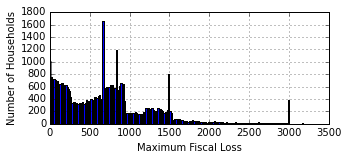

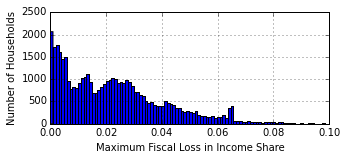

In [98]:
#Histogramme de la plus grosse perte fiscale possible
plt.figure(figsize=(5,2))
(df2013_A[filter_pay_tax].result_max_allocation - df2013_A[filter_pay_tax].result_min_allocation).hist(bins = 1000)
plt.xlim(0,3500); 
plt.ylabel("Number of Households", )
plt.xlabel("Maximum Fiscal Loss")

#Histogramme de la plus grosse perte fiscale possible
plt.figure(figsize=(5,2))


maximum_fiscal_loss_in_share_of_RNI[(maximum_fiscal_loss_in_share_of_RNI>0)& (maximum_fiscal_loss_in_share_of_RNI<0.1)].hist(bins = 100)
plt.ylabel("Number of Households",)
plt.xlabel("Maximum Fiscal Loss in Income Share",)
plt.xlim(0,0.1); 

In [99]:
(maximum_fiscal_loss_in_share_of_RNI[maximum_fiscal_loss_in_share_of_RNI>0.0]>0.01).mean()

0.70206626134461181

In [100]:
(maximum_fiscal_loss_in_share_of_RNI>0.0).mean()

0.88681383082633325

In [101]:
maximum_fiscal_loss_in_share_of_RNI.mean()

0.021391596329123824

In [102]:
maximum_fiscal_loss_in_share_of_RNI.median()

0.017123382992259573

In [103]:
print (maximum_fiscal_loss_in_share_of_RNI>0.005).value_counts(normalize = True)
print (maximum_fiscal_loss_in_share_of_RNI>0.01).value_counts(normalize = True)

True    0.72
False   0.28
dtype: float64
True    0.62
False   0.38
dtype: float64


### Number of optimal allocations

In [104]:
df_A.Number_of_optimal_allocations_2013.value_counts() #Errors for 36 and 12, checked the other situations seems ok.

1.00     30831
2.00      3712
3.00      1651
4.00       319
5.00       158
7.00        20
6.00        20
36.00        4
12.00        2
dtype: int64

In [105]:
df2013_A.Number_of_optimal_allocations.value_counts()

1.00     42470
2.00      5457
3.00      2466
4.00       478
5.00       242
7.00        36
6.00        33
12.00        4
18.00        2
14.00        2
dtype: int64

#### 2013

In [106]:
df_temp = df2013_A[df2013_A.Number_of_optimal_allocations<12]
df_child_number = pd.DataFrame()
for child in range(1,7):
    for number_of_alloc in range(1,8):
        df_child_number.loc[child, number_of_alloc] = (df_temp.query("Nb_enfants == {}".format(child)).Number_of_optimal_allocations == number_of_alloc).sum()
df_child_number      

,1,2,3,4,5,6,7
1,24203.00,3113.00,0.00,0.00,0.00,0.00,0.00
2,16525.00,1831.00,2051.00,2.00,0.00,2.00,0.00
3,1457.00,345.00,253.00,344.00,0.00,0.00,0.00
4,271.00,159.00,145.00,109.00,225.00,0.00,0.00
5,6.00,4.00,11.00,5.00,1.00,14.00,0.00
6,8.00,5.00,6.00,18.00,16.00,17.00,36.00


In [107]:
df_temp = df2013_A[df2013_A.Number_of_optimal_allocations<12]
df_child_number = pd.DataFrame()
for child in range(1,7):
    for number_of_alloc in range(1,8):
        df_child_number.loc[child, number_of_alloc] = (df_temp.query("Nb_enfants == {}".format(child)).Number_of_optimal_allocations == number_of_alloc).sum()/ len(df_temp.query("Nb_enfants == {}".format(child)))*100
        

In [108]:
df_child_number.index.name = 'Number of children'
df_child_number.axes[1].name = "Number of optimal allocations"
df_child_number.loc[2,4] = 0 # On vire les 4 ménages de deux enfants qui ont 4 ou 6 allocations optimales (do not know where it comes from)
df_child_number.loc[2,6] = 0 

df_child_number["Total"] = [ len(df_temp.query("Nb_enfants == {}".format(child))) for child in range(1,7)]
df_child_number.loc["Total" ] = [len(df_temp.query("Number_of_optimal_allocations == {}".format(number_of_alloc))) for number_of_alloc in range(1,8)] + [df_child_number["Total"].sum()]
df_child_number.loc["Share"] = df_child_number.loc["Total"]/df_child_number.loc["Total", "Total"]
df_child_number.replace(0, "")

Number of optimal allocations,1,2,3,4,5,6,7,Total
Number of children,,,,,,,,
1,88.60,11.40,,,,,,27316.00
2,80.96,8.97,10.05,,,,,20411.00
3,60.73,14.38,10.55,14.34,,,,2399.00
4,29.81,17.49,15.95,11.99,24.75,,,909.00
5,14.63,9.76,26.83,12.20,2.44,34.15,,41.00
6,7.55,4.72,5.66,16.98,15.09,16.04,33.96,106.00
Total,42470.00,5457.00,2466.00,478.00,242.00,33.00,36.00,51182.00
Share,0.83,0.11,0.05,0.01,0.00,0.00,0.00,1.00


In [109]:
df_temp = df2013_A[df2013_A.Number_of_optimal_allocations<12]

df_child_number = pd.DataFrame()
for child in range(1,7):
    for number_of_alloc in range(1,8):
        df_child_number.loc[child, number_of_alloc] = (df_temp.query("Nb_enfants == {}".format(child)).Number_of_optimal_allocations == number_of_alloc).sum()/ len(df_temp.query("Nb_enfants == {}".format(child)))*100
        
df_child_number.index.name = 'Number of children'
df_child_number.axes[1].name = "Number of optimal allocations"
df_child_number.loc[2,4] = 0 # On vire les 4 ménages de deux enfants qui ont 4 ou 6 allocations optimales (do not know where it comes from)
df_child_number.loc[2,6] = 0 




df_child_number["Total"] = [ len(df_temp.query("Nb_enfants == {}".format(child))) for child in range(1,7)]
df_child_number.loc["Total" ] = [len(df_temp.query("Number_of_optimal_allocations == {}".format(number_of_alloc))) for number_of_alloc in range(1,8)] + [df_child_number["Total"].sum()]
df_child_number.loc["Share"] = df_child_number.loc["Total"]/df_child_number.loc["Total", "Total"]
df_child_number.replace(0, "")

Number of optimal allocations,1,2,3,4,5,6,7,Total
Number of children,,,,,,,,
1,88.60,11.40,,,,,,27316.00
2,80.96,8.97,10.05,,,,,20411.00
3,60.73,14.38,10.55,14.34,,,,2399.00
4,29.81,17.49,15.95,11.99,24.75,,,909.00
5,14.63,9.76,26.83,12.20,2.44,34.15,,41.00
6,7.55,4.72,5.66,16.98,15.09,16.04,33.96,106.00
Total,42470.00,5457.00,2466.00,478.00,242.00,33.00,36.00,51182.00
Share,0.83,0.11,0.05,0.01,0.00,0.00,0.00,1.00


### PACS

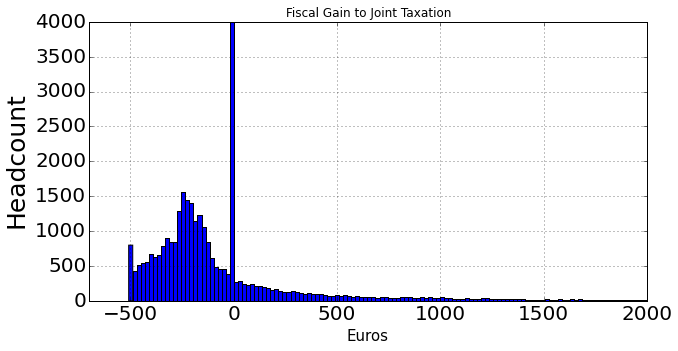

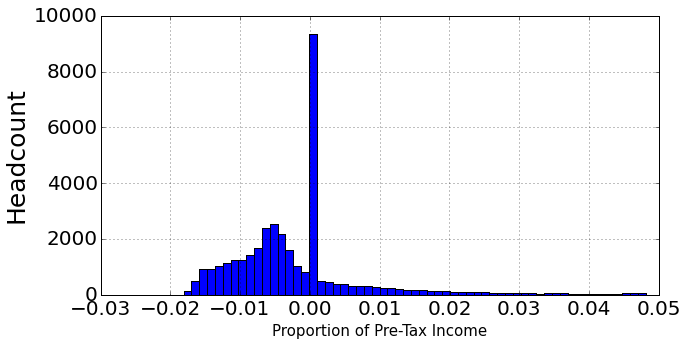

In [110]:
plt.figure(figsize=(10,5))
plt.rc("xtick", labelsize = 20)
plt.rc("ytick", labelsize = 20)
(df_A.result_min_allocation_2013 - df_A.Irpp_decote_pacs).hist(bins =900)
plt.xlim(-700,2000)
plt.ylim(0,4000)
plt.ylabel("Headcount", fontsize = 25); plt.xlabel("Euros", fontsize = 15)
plt.title("Fiscal Gain to Joint Taxation")
#In share of income
plt.figure(figsize=(10,5))
plt.rc("xtick", labelsize = 20)
plt.rc("ytick", labelsize = 20)
((df_A.result_min_allocation_2013 - df_A.Irpp_decote_pacs)/df_A.Rni_2013).hist(bins =10000)
plt.xlim(-0.03,0.05)
#plt.ylim(0,4000)
plt.ylabel("Headcount", fontsize = 25); plt.xlabel("Proportion of Pre-Tax Income", fontsize = 15)


In [111]:
print ((df2013_A.result_min_allocation- df2013_A.Irpp_decote_pacs)>20).value_counts(normalize = True)### gagnent au pacs
print ((df2013_A.result_min_allocation - df2013_A.Irpp_decote_pacs)<-20).value_counts(normalize = True)#perdent au pacs
print (np.abs((df2013_A.result_min_allocation - df2013_A.Irpp_decote_pacs))<20).value_counts(normalize = True)#neutre 

False   0.82
True    0.18
dtype: float64
True    0.55
False   0.45
dtype: float64
False   0.72
True    0.28
dtype: float64


Most households in the sample would loose to joint taxation.

In [112]:
%%time
i = 0
two_smallest_difference = np.array([])
for df_temp in [df2013_A]:
    for series in df_temp[["Irpp_decote_allocation_{}".format(alloc_nb) for alloc_nb in range(1,9)]].iterrows():
        two_smallest_allocations =  series[1].nsmallest(2)
        i+=1
        two_smallest_difference = np.append(two_smallest_difference,  two_smallest_allocations[0] - two_smallest_allocations[1]) 
    df_temp["Two_smallest_allocation_difference"] = -pd.Series(two_smallest_difference)


Wall time: 20.2 s


# Impôt (stat des)

In [113]:
df2013_A.Irpp_decote.describe()

count     51190.00
mean       2061.58
std        8580.01
min           0.00
25%          89.05
50%         893.84
75%        2177.91
max     1367912.93
Name: Irpp_decote, dtype: float64

In [114]:
print (df2013_A.Irpp_decote<1).value_counts(normalize = True)
print (df2013_A.Irpp_decote<1).value_counts(normalize = False)

False   0.79
True    0.21
dtype: float64
False    40549
True     10641
dtype: int64


In [115]:
df2013_A[df2013_A.Irpp_decote>0].Irpp_decote.describe()

count     40570.00
mean       2601.24
std        9564.72
min           0.05
25%         514.64
50%        1335.68
75%        2619.69
max     1367912.93
Name: Irpp_decote, dtype: float64

(0, 0.4)

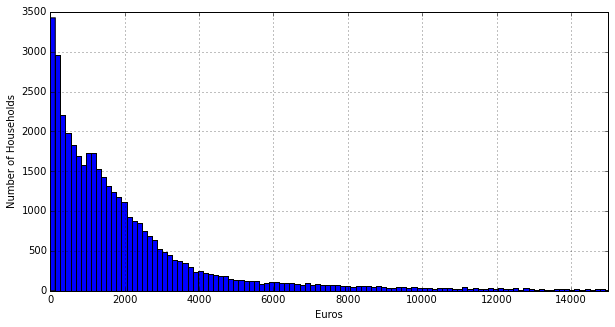

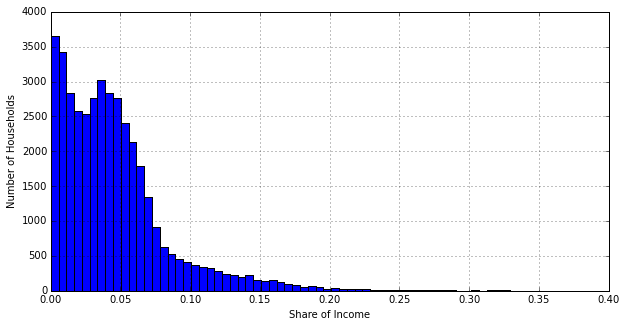

In [116]:
plt.figure(figsize = (10,5))
plt.rc("xtick", labelsize = 10)
plt.rc("ytick", labelsize = 10)
df2013_A[df2013_A.Irpp_decote>0].Irpp_decote.hist(bins = 10000)
plt.xlabel("Euros", fontsize = 10); plt.ylabel("Number of Households", fontsize = 10)
plt.xlim(1,15000)

plt.figure(figsize = (10,5))
plt.rc("xtick", labelsize = 10)
plt.rc("ytick", labelsize = 10)
(df2013_A[df2013_A.Irpp_decote>0].Irpp_decote/df2013_A[df2013_A.Irpp_decote>0].Rni).hist(bins = 5000)
plt.xlabel("Share of Income", fontsize = 10); plt.ylabel("Number of Households", fontsize = 10)
plt.xlim(0,0.4)

### Do not optimize stat des

#### 2013

In [117]:
for key, df_temp in {"All": df2013_A, "Can optimize": df2013_B, "Unique opt allocation": df2013_D, }.iteritems(): #[df2014_B.Two_smallest_allocation_difference !=0]
    print key + "\n"            
    print df_temp.Do_not_optimize.value_counts(normalize = True)[True]
    print df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize = True)[True]
    print df_temp.shape[0]

Unique opt allocation

0.291313559322
0.0954331450094
42480
All

0.248153936316
0.0824575112327
51190
Can optimize

0.279733985158
0.0929510471031
45411


In [118]:
df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize = True).loc[True]

0.092951047103124795

In [119]:
for number_of_optimal_allocation in range(1,5):
    filter_ = df2013_B.Number_of_optimal_allocations == number_of_optimal_allocation
    df_temp = df2013_B[filter_]
    print str(number_of_optimal_allocation) + "\n"            
    print 1-df_temp.Do_not_optimize.value_counts(normalize = True)[False]
    print 1-df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize = True)[False]
    print df_temp.shape[0]

1

0.291335060042
0.0954085236638
42470
2

0.130527210884
0.0663265306122
2352
3

0.0481927710843
0.0289156626506
415
4

0.0149253731343
0.0
134


In [120]:
#### 2014

In [121]:
for key, df_temp in {"All": df2014_A, "Can optimize": df2014_B, "Unique opt allocation": df2014_D}.iteritems(): #[df2014_B.Two_smallest_allocation_difference !=0]
    print key + "\n"            
    print df_temp.Do_not_optimize.value_counts(normalize = True)[True]
    print df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize = True)[True]
    print df_temp.shape[0]

Unique opt allocation

0.286010973796
0.125506384288
39002
All

0.217457655858
0.0973868153814
53077
Can optimize

0.257524710502
0.115330551775
44819


###### 2013 With diplomas

In [122]:
for key, df_temp in {"All": df2013_A, "Can optimize": df2013_B, "Unique opt allocation": df2013_D, }.iteritems(): #[df2014_B.Two_smallest_allocation_difference !=0]
    print key             
    df_temp = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2] 
    print df_temp.Do_not_optimize.value_counts(normalize = True)[True]
    print df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize = True)[True]
    print df_temp.shape[0]

Unique opt allocation
0.290462584542
0.0916488842273
27649
All
0.254490276229
0.081475287997
32292
Can optimize
0.279466775488
0.0894715364211
29406


###### 2014 With diplomas

In [123]:
for key, df_temp in {"All": df2014_A, "Can optimize": df2014_B, "Unique opt allocation": df2014_D}.iteritems(): #[df2014_B.Two_smallest_allocation_difference !=0]
    print key
    df_temp = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2] 
    print df_temp.Do_not_optimize.value_counts(normalize = True)[True]
    print df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize = True)[True]
    print df_temp.shape[0]

Unique opt allocation
0.298640588899
0.126376873892
18611
All
0.238805970149
0.103399668325
24120
Can optimize
0.268031642624
0.116053978595
21490


In [124]:
df2013_A.Do_not_optimize.value_counts(normalize = True)

False   0.75
True    0.25
dtype: float64

In [125]:
df2013_B.Do_not_optimize.value_counts(normalize = True)

False   0.72
True    0.28
dtype: float64

#### Fiscal loss

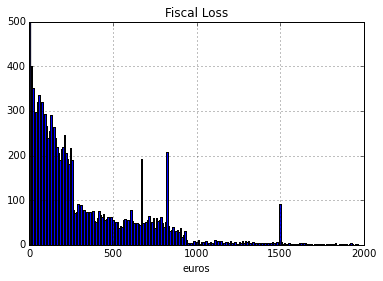

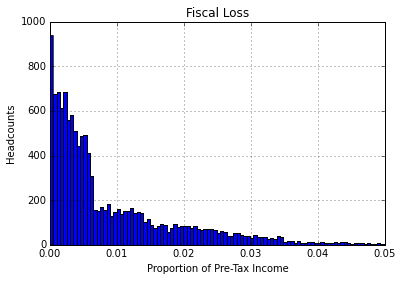

In [126]:
plt.figure()
df2013_B.Fiscal_loss.hist(bins = 1000)
plt.xlim(0,2000)
plt.ylim(0,500); plt.xlabel("euros")
plt.title("Fiscal Loss")
## In share of income

plt.figure()
df2013_B["Fiscal_loss_in_share_of_income"] = (df2013_B.Fiscal_loss/df2013_B.Rni)
df2013_B.query("0.05>Fiscal_loss_in_share_of_income>0").Fiscal_loss_in_share_of_income.hist(bins = 100)
plt.xlabel("Proportion of Pre-Tax Income"); plt.ylabel("Headcounts")
plt.title("Fiscal Loss")

### Potential Maximal Fiscal loss + actual fiscal loss in share of income (article graph)

In [127]:
def tex_font(string = None):
    string = "$"+string+"$"
    return string.replace(" ", "\,")
    

In [128]:
plt.rc("xtick", labelsize = 20)
plt.rc("ytick", labelsize = 20)

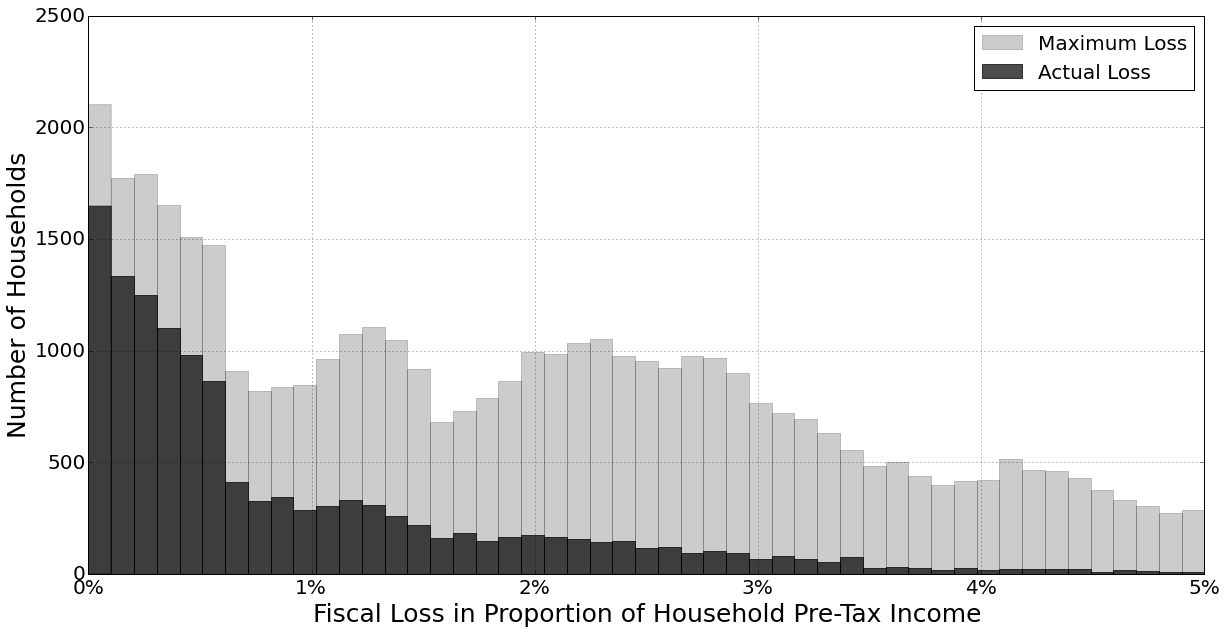

In [129]:
## To put in article

plt.figure(figsize=(20,10))
bins = np.linspace(0,0.05,50)

maximum_fiscal_loss_in_share_of_RNI[(maximum_fiscal_loss_in_share_of_RNI>0)& (maximum_fiscal_loss_in_share_of_RNI<0.1)].hist(bins = bins, color = 'k', alpha = 0.2, label = "Maximum Loss")
df2013_B.query("0.1>Fiscal_loss_in_share_of_income>0").Fiscal_loss_in_share_of_income.hist(bins = bins, color = "k", alpha = 0.7, label = "Actual Loss")
plt.ylabel("Number of Households", fontsize = 25)
plt.xlabel("Fiscal Loss in Proportion of Household Pre-Tax Income", fontsize = 25)
plt.xlim(0,0.05) ; plt.legend( fontsize = 20)
plt.gca().set_xticklabels([u"{:.0f}%".format(x*100) for x in plt.gca().get_xticks()])

### Stat des de la partie cooperation

In [130]:
ID_FISC_LOG_DIFF_2014 = df2014_A.ID_FISC_LOG_DIFF

In [131]:
df2013_A["Still_cohabitants"] = ((df2013_A[["Separation","Pacs", "Mariage"]].sum(axis = 1)==0)
                                 & df2013_A.ID_FISC_LOG_DIFF.isin(ID_FISC_LOG_DIFF_2014))


df2013_B["Still_cohabitants"] = ((df2013_B[["Separation","Pacs", "Mariage"]].sum(axis = 1)==0)
                                 & df2013_B.ID_FISC_LOG_DIFF.isin(ID_FISC_LOG_DIFF_2014))

In [132]:
print df2013_A[df2013_A.Separation].Fiscal_loss.mean()
print df2013_A[df2013_A.Mariage].Fiscal_loss.mean()
print df2013_A[df2013_A.Pacs].Fiscal_loss.mean()
print df2013_A[df2013_A.Still_cohabitants].Fiscal_loss.mean()

95.8034262673
89.5952091078
106.562742915
82.2567424614


In [133]:
pd.options.display.float_format = '{:.3f}'.format

In [134]:
def t_test_still_cohab(df_temp_all, df_temp, var):
    weight_stat_des_stil_cohab =   statsmodels.stats.weightstats.DescrStatsW(df_temp_all[df_temp_all["Still_cohabitants"]][var])
    weight_stat_des_other_status =   statsmodels.stats.weightstats.DescrStatsW(df_temp[var])
    t_test = statsmodels.stats.weightstats.CompareMeans(weight_stat_des_stil_cohab,weight_stat_des_other_status).ttest_ind()
    return t_test
def summary_still_cohab(df_temp_all, df_temp, var):
    weight_stat_des_stil_cohab =   statsmodels.stats.weightstats.DescrStatsW(df_temp_all[df_temp_all["Still_cohabitants"]][var])
    weight_stat_des_other_status =   statsmodels.stats.weightstats.DescrStatsW(df_temp[var])
    hello = statsmodels.stats.weightstats.CompareMeans(weight_stat_des_stil_cohab,weight_stat_des_other_status)
    return hello

####All

In [135]:
df_desc = pd.DataFrame()
for status in ["Still_cohabitants", "Separation", "Mariage","Pacs"]:
    df_temp_ref = df2013_A[(df2013_A.ID_FISC_LOG_DIFF.isin(ID_FISC_LOG_DIFF_2014))| (df2013_A[["Separation","Pacs", "Mariage"]].sum(axis = 1)>0)]

    
    
    df_temp_still_cohab = df_temp_ref[df_temp_ref["Still_cohabitants"]]
    df_temp= df_temp_ref[df_temp_ref[status]]

    
    for var in ["Fiscal_loss", "Do_not_optimize", "Do_not_optimize_1_prct_income_share"]+var_list+["Nb_enfants"]:
        df_desc.loc["Mean {}".format(var), status] = df_temp[var].mean()
        df_desc.loc["Mean {}".format(var), status[:3]+"_t-stat"]  =   t_test_still_cohab(df_temp_still_cohab, df_temp, var)[0]
        df_desc.loc["Mean {}".format(var), status[:3]+"_p-value"]  =   t_test_still_cohab(df_temp_still_cohab, df_temp, var)[1]
        df_desc.loc["Mean {}".format(var), status] = df_temp[var].mean()#.astype("str")[:4]
    
    for child in range(1,5):
        # Var == Nb_enfants
        if child<4:         
            df_desc.loc["N_obs_{}_child".format(child), status] = len(df_temp.query("Nb_enfants == {}".format(child)))
            df_desc.loc["Share_{}_child".format(child), status] = len(df_temp.query("Nb_enfants == {}".format(child)))/len(df_temp)
            df_desc.loc["Share_{}_child".format(child), status[:3]+"_t-stat"]  =    sm.stats.ttest_ind(df_temp_still_cohab.Nb_enfants == child, df_temp.Nb_enfants ==child)[0]
            df_desc.loc["Share_{}_child".format(child), status[:3]+"_p-value"]  =  sm.stats.ttest_ind(df_temp_still_cohab.Nb_enfants == child, df_temp.Nb_enfants ==child)[1]
            for var_2 in ['Age_moyen_children', 'Age_elder_child','Age_younger_child']:
                df_desc.loc["Mean {} {}_child".format(var_2, child), status] = df_temp.query("Nb_enfants == {}".format(child))[var_2].mean()
                df_desc.loc["Mean {} {}_child".format(var_2, child),  status[:3]+"_t-stat"] = t_test_still_cohab(df_temp_still_cohab.query("Nb_enfants == {}".format(child)),df_temp.query("Nb_enfants == {}".format(child)), var_2)[0]
                df_desc.loc["Mean {} {}_child".format(var_2, child),  status[:3]+"_p-value"] = t_test_still_cohab(df_temp_still_cohab.query("Nb_enfants == {}".format(child)),df_temp.query("Nb_enfants == {}".format(child)), var_2)[1]
            
        else: 
            df_desc.loc["N_obs_{}_child_and_more".format(child), status] = len(df_temp.query("Nb_enfants >= {}".format(child)))
            df_desc.loc["Share_{}_child_and_more".format(child), status] = len(df_temp.query("Nb_enfants >= {}".format(child)))/len(df_temp)
            df_desc.loc["Share_{}_child_and_more".format(child), status[:3]+"_t-stat"]  =    sm.stats.ttest_ind(df_temp_still_cohab.Nb_enfants >= child, df_temp.Nb_enfants >=child)[0]
            df_desc.loc["Share_{}_child_and_more".format(child), status[:3]+"_p-value"]  =  sm.stats.ttest_ind(df_temp_still_cohab.Nb_enfants >= child, df_temp.Nb_enfants >=child)[1]
            for var_2 in ['Age_moyen_children', 'Age_elder_child','Age_younger_child']:
                df_desc.loc["Mean {} {}_child_and_more".format(var_2, child), status] = df_temp.query("Nb_enfants >= {}".format(child))[var_2].mean()
                df_desc.loc["Mean {} {}_child_and_more".format(var_2, child), status] = df_temp.query("Nb_enfants == {}".format(child))[var_2].mean()
                df_desc.loc["Mean {} {}_child_and_more".format(var_2, child), status[:3]+"_t-stat"] = t_test_still_cohab(df_temp_still_cohab.query("Nb_enfants >= {}".format(child)),df_temp.query("Nb_enfants >= {}".format(child)), var_2)[0]
                df_desc.loc["Mean {} {}_child_and_more".format(var_2, child), status[:3]+"_p-value"] = t_test_still_cohab(df_temp_still_cohab.query("Nb_enfants >= {}".format(child)),df_temp.query("Nb_enfants >= {}".format(child)), var_2)[1]
                
    df_desc.loc["Share", status] = len(df_temp)/len(df_temp_ref)
    df_desc.loc["N_obs", status] = len(df_temp)
    
    

for status in ["Still_cohabitants", "Separation", "Mariage","Pacs"]:
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.1, status] = df_desc[status].astype("str").str[:5] + "*"
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.05, status] = df_desc[status].astype("str").str[:5] + "**"
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.01, status] = df_desc[status].astype("str").str[:5] + "***"
df_desc.drop(labels = ["Sti_t-stat","Sti_p-value"], axis = 1).fillna("")

,Still_cohabitants,Separation,Sep_t-stat,Sep_p-value,Mariage,Mar_t-stat,Mar_p-value,Pacs,Pac_t-stat,Pac_p-value
Mean Fiscal_loss,82.257,95.80*,-1.753,0.080,89.595,-1.051,0.293,106.5***,-2.978,0.003
Mean Do_not_optimize,0.252,0.240,0.941,0.347,0.259,-0.541,0.589,0.278*,-1.864,0.062
Mean Do_not_optimize_1_prct_income_share,0.079,0.109***,-3.625,0.000,0.079,0.072,0.943,0.089,-1.114,0.265
Mean Rni,36098.544,30610***,6.477,0.000,36664.364,-0.738,0.461,43544***,-8.340,0.000
Mean Rni_pere,20892.545,18033***,4.423,0.000,22319**,-2.436,0.015,26048***,-7.562,0.000
Mean Rni_mere,15205.999,12577***,6.038,0.000,14345**,2.197,0.028,17495***,-4.979,0.000
Mean Diff_in_incompe_mere_pere,10133.448,10034.603,0.151,0.880,11469**,-2.255,0.024,13769***,-5.240,0.000
Mean Age_moyen_parents,34.443,32.80***,8.439,0.000,32.41***,11.690,0.000,32.54***,9.422,0.000
Mean Age_pere,35.567,33.96***,7.530,0.000,33.51***,10.728,0.000,33.41***,9.682,0.000
Mean Age_mere,33.318,31.65***,8.514,0.000,31.31***,11.467,0.000,31.66***,8.113,0.000


In the above table, tstats are means comparison against Still_cohabitants as reference.


In [136]:
#Taux separation global
print(df2013_A.Separation.mean())
#Taux separation optimiseurs
print(df2013_A[~df2013_A.Do_not_optimize].Separation.mean())
#Taux separation non optimiseurs
print(df2013_A[df2013_A.Do_not_optimize].Separation.mean())
#Taux separation non optimiseurs 1 %
print(df2013_A[df2013_A.Do_not_optimize_1_prct_income_share].Separation.mean())


0.0211955460051
0.0214358094941
0.0204676060773
0.028192371476


In [137]:
df_A["Optimize_2014"] = ~df_A.Do_not_optimize_2014

In [138]:
df2013_A_df_A = pd.merge(df2013_A, df_A, on = "ID_FISC_LOG_DIFF", how = "left")

In [139]:
df_desc = pd.DataFrame()
for var in ["Still_cohabitants","Separation", "Mariage", "Pacs"]:
    df_desc.loc[var, "All"] = df2013_A[var].mean()*100
    df_desc.loc[var, "Opt"] = df2013_A[~df2013_A.Do_not_optimize][var].mean()*100
    df_desc.loc[var, "DNO"] = df2013_A[df2013_A.Do_not_optimize][var].mean()*100
    df_desc.loc[var, "Opt_1_prct"] = df2013_A[~df2013_A.Do_not_optimize_1_prct_income_share][var].mean()*100
    df_desc.loc[var, "DNO_1_prct"] = df2013_A[df2013_A.Do_not_optimize_1_prct_income_share][var].mean()*100

    

In [140]:
df_desc

,All,Opt,DNO,Opt_1_prct,DNO_1_prct
Still_cohabitants,71.715,71.328,72.888,71.958,69.012
Separation,2.120,2.144,2.047,2.057,2.819
Mariage,2.627,2.590,2.740,2.638,2.511
Pacs,1.930,1.853,2.165,1.916,2.085


In [141]:
print df_A[df_A.Do_not_optimize_2013].Do_not_optimize_2014.mean()
print df_A[df_A.Do_not_optimize_2013].Separation.mean()*100

0.58462036937
0.0


In [142]:
df_desc = pd.DataFrame()
shape = df2013_A_df_A[df2013_A_df_A.Do_not_optimize].shape[0]
print df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Do_not_optimize_2014.sum()/shape
print df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Optimize_2014.sum()/shape
print df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Separation_x.sum()/shape
print df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Mariage_x.sum()/shape
print df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Pacs_x.sum()/shape

0.426119814217
0.30276312682
0.0204676060773
0.0273951035189
0.0216484295048


In [143]:
df_desc = pd.DataFrame()
shape = df2013_A_df_A[df2013_A_df_A.Do_not_optimize].shape[0]
df_desc.loc["DNO", " "] = df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Do_not_optimize_2014.sum()/shape
df_desc.loc["Optimize", " "] = df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Optimize_2014.sum()/shape
df_desc.loc["Separate", " "] = df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Separation_x.sum()/shape
df_desc.loc["Married", " "] = df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Mariage_x.sum()/shape
df_desc.loc["Pacs", " "] = df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Pacs_x.sum()/shape
somme = df_desc.sum()
df_desc.loc["Total", " "] = float(somme)

In [144]:
df_desc

,
DNO,0.426
Optimize,0.303
Separate,0.020
Married,0.027
Pacs,0.022
Total,0.798


In [145]:
df_desc.sum()

    1.597
dtype: float64

In [146]:
df2013_A.shape

(51190, 280)

In [147]:
df_A.shape

(36717, 421)

### Groupe B

In [148]:
df_desc = pd.DataFrame()
for status in ["Still_cohabitants", "Separation", "Mariage","Pacs"]:
    df_temp_ref = df2013_B[(df2013_B.ID_FISC_LOG_DIFF.isin(ID_FISC_LOG_DIFF_2014))| (df2013_B[["Separation","Pacs", "Mariage"]].sum(axis = 1)>0)]

    
    
    df_temp_still_cohab = df_temp_ref[df_temp_ref["Still_cohabitants"]]
    df_temp= df_temp_ref[df_temp_ref[status]]

    
    for var in ["Fiscal_loss", "Do_not_optimize", "Do_not_optimize_1_prct_income_share"]+var_list+["Nb_enfants"]:
        df_desc.loc["Mean {}".format(var), status] = df_temp[var].mean()
        df_desc.loc["Mean {}".format(var), status[:3]+"_t-stat"]  =   t_test_still_cohab(df_temp_still_cohab, df_temp, var)[0]
        df_desc.loc["Mean {}".format(var), status[:3]+"_p-value"]  =   t_test_still_cohab(df_temp_still_cohab, df_temp, var)[1]
        df_desc.loc["Mean {}".format(var), status] = df_temp[var].mean()#.astype("str")[:4]
    
    for child in range(1,5):
        # Var == Nb_enfants
        if child<4:         
            df_desc.loc["N_obs_{}_child".format(child), status] = len(df_temp.query("Nb_enfants == {}".format(child)))
            df_desc.loc["Share_{}_child".format(child), status] = len(df_temp.query("Nb_enfants == {}".format(child)))/len(df_temp)
            df_desc.loc["Share_{}_child".format(child), status[:3]+"_t-stat"]  =    sm.stats.ttest_ind(df_temp_still_cohab.Nb_enfants == child, df_temp.Nb_enfants ==child)[0]
            df_desc.loc["Share_{}_child".format(child), status[:3]+"_p-value"]  =  sm.stats.ttest_ind(df_temp_still_cohab.Nb_enfants == child, df_temp.Nb_enfants ==child)[1]
            for var_2 in ['Age_moyen_children', 'Age_elder_child','Age_younger_child']:
                df_desc.loc["Mean {} {}_child".format(var_2, child), status] = df_temp.query("Nb_enfants == {}".format(child))[var_2].mean()
                df_desc.loc["Mean {} {}_child".format(var_2, child),  status[:3]+"_t-stat"] = t_test_still_cohab(df_temp_still_cohab.query("Nb_enfants == {}".format(child)),df_temp.query("Nb_enfants == {}".format(child)), var_2)[0]
                df_desc.loc["Mean {} {}_child".format(var_2, child),  status[:3]+"_p-value"] = t_test_still_cohab(df_temp_still_cohab.query("Nb_enfants == {}".format(child)),df_temp.query("Nb_enfants == {}".format(child)), var_2)[1]
            
        else: 
            df_desc.loc["N_obs_{}_child_and_more".format(child), status] = len(df_temp.query("Nb_enfants >= {}".format(child)))
            df_desc.loc["Share_{}_child_and_more".format(child), status] = len(df_temp.query("Nb_enfants >= {}".format(child)))/len(df_temp)
            df_desc.loc["Share_{}_child_and_more".format(child), status[:3]+"_t-stat"]  =    sm.stats.ttest_ind(df_temp_still_cohab.Nb_enfants >= child, df_temp.Nb_enfants >=child)[0]
            df_desc.loc["Share_{}_child_and_more".format(child), status[:3]+"_p-value"]  =  sm.stats.ttest_ind(df_temp_still_cohab.Nb_enfants >= child, df_temp.Nb_enfants >=child)[1]
            for var_2 in ['Age_moyen_children', 'Age_elder_child','Age_younger_child']:
                df_desc.loc["Mean {} {}_child_and_more".format(var_2, child), status] = df_temp.query("Nb_enfants >= {}".format(child))[var_2].mean()
                df_desc.loc["Mean {} {}_child_and_more".format(var_2, child), status] = df_temp.query("Nb_enfants == {}".format(child))[var_2].mean()
                df_desc.loc["Mean {} {}_child_and_more".format(var_2, child), status[:3]+"_t-stat"] = t_test_still_cohab(df_temp_still_cohab.query("Nb_enfants >= {}".format(child)),df_temp.query("Nb_enfants >= {}".format(child)), var_2)[0]
                df_desc.loc["Mean {} {}_child_and_more".format(var_2, child), status[:3]+"_p-value"] = t_test_still_cohab(df_temp_still_cohab.query("Nb_enfants >= {}".format(child)),df_temp.query("Nb_enfants >= {}".format(child)), var_2)[1]
                
    df_desc.loc["Share", status] = len(df_temp)/len(df_temp_ref)
    df_desc.loc["N_obs", status] = len(df_temp)
    
    

for status in ["Still_cohabitants", "Separation", "Mariage","Pacs"]:
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.1, status] = df_desc[status].astype("str").str[:5] + "*"
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.05, status] = df_desc[status].astype("str").str[:5] + "**"
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.01, status] = df_desc[status].astype("str").str[:5] + "***"
df_desc.drop(labels = ["Sti_t-stat","Sti_p-value"], axis = 1).fillna("")

,Still_cohabitants,Separation,Sep_t-stat,Sep_p-value,Mariage,Mar_t-stat,Mar_p-value,Pacs,Pac_t-stat,Pac_p-value
Mean Fiscal_loss,91.863,114.4**,-2.550,0.011,96.947,-0.666,0.505,112.7**,-2.366,0.018
Mean Do_not_optimize,0.282,0.286,-0.309,0.757,0.280,0.131,0.896,0.294,-0.855,0.393
Mean Do_not_optimize_1_prct_income_share,0.089,0.131***,-4.415,0.000,0.085,0.407,0.684,0.094,-0.594,0.553
Mean Rni,36755.834,33412***,6.397,0.000,37447.769,-1.513,0.130,42468***,-10.951,0.000
Mean Rni_pere,21420.867,19829***,4.027,0.000,22932***,-4.357,0.000,25839***,-11.083,0.000
Mean Rni_mere,15334.967,13583***,5.762,0.000,14515***,3.135,0.002,16628***,-4.313,0.000
Mean Diff_in_incompe_mere_pere,10371.737,11040*,-1.764,0.078,11777***,-4.253,0.000,13418***,-7.938,0.000
Mean Age_moyen_parents,34.552,33.30***,6.059,0.000,32.53***,11.435,0.000,32.48***,10.180,0.000
Mean Age_pere,35.649,34.38***,5.532,0.000,33.61***,10.454,0.000,33.34***,10.275,0.000
Mean Age_mere,33.455,32.21***,5.963,0.000,31.45***,11.235,0.000,31.62***,8.943,0.000


### Diplomas only

In [149]:
df_desc = pd.DataFrame()
for status in ["Still_cohabitants", "Separation", "Mariage","Pacs"]:
    df_temp = df2013_A[(df2013_A.ID_FISC_LOG_DIFF.isin(ID_FISC_LOG_DIFF_2014))| (df2013_A[["Separation","Pacs", "Mariage"]].sum(axis = 1)>0)]
    df_temp_diplomas_all = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
    df_temp_diplomas = df_temp_diplomas_all[df_temp_diplomas_all[status]]
    df_temp_diplomas_still_cohab = df_temp_diplomas_all[df_temp_diplomas_all["Still_cohabitants"]]
    
    for var in ["Fiscal_loss", "Do_not_optimize", "Do_not_optimize_1_prct_income_share"]+var_list+diploma_4_categories:
        df_desc.loc["Mean {}".format(var), status] = df_temp_diplomas[var].mean()
        df_desc.loc["Mean {}".format(var), status[:3]+"_t-stat"]  =   t_test_still_cohab(df_temp_still_cohab, df_temp_diplomas, var)[0]
        df_desc.loc["Mean {}".format(var), status[:3]+"_p-value"]  =   t_test_still_cohab(df_temp_still_cohab, df_temp_diplomas, var)[1]
        df_desc.loc["Mean {}".format(var), status] = df_temp_diplomas[var].mean()#.astype("str")[:4]
    df_desc.loc["Share", status] = len(df_temp_diplomas)/len(df_temp_still_cohab)
    df_desc.loc["N_obs", status] = len(df_temp_diplomas)
    
    for child in range(1,5):
            if child<4: 
                df_desc.loc["N_obs_{}_child".format(child), status] = len(df_temp_diplomas.query("Nb_enfants == {}".format(child)))
                df_desc.loc["Share_{}_child".format(child), status] = len(df_temp_diplomas.query("Nb_enfants == {}".format(child)))/len(df_temp_diplomas)
                df_desc.loc["Share_{}_child".format(child), status[:3]+"_t-stat"]  =   t_test_still_cohab(df_temp_diplomas_still_cohab.query("Nb_enfants == {}".format(child)), df_temp_diplomas.query("Nb_enfants == {}".format(child)), var)[0]
                df_desc.loc["Share_{}_child".format(child), status[:3]+"_p-value"]  =   t_test_still_cohab(df_temp_diplomas_still_cohab.query("Nb_enfants == {}".format(child)), df_temp_diplomas.query("Nb_enfants == {}".format(child)), var)[1]
            else: 
                df_desc.loc["N_obs_{}_child_and_more".format(child), status] = len(df_temp_diplomas.query("Nb_enfants >= {}".format(child)))
                df_desc.loc["Share_{}_child_and_more".format(child), status] = len(df_temp_diplomas.query("Nb_enfants >= {}".format(child)))/len(df_temp_diplomas)
                df_desc.loc["Share_{}_child_and_more".format(child), status[:3]+"_t-stat"]  =   t_test_still_cohab(df_temp_diplomas_still_cohab.query("Nb_enfants >= {}".format(child)), df_temp_diplomas.query("Nb_enfants >= {}".format(child)), var)[0]
                df_desc.loc["Share_{}_child_and_more".format(child), status[:3]+"_p-value"]  =   t_test_still_cohab(df_temp_diplomas_still_cohab.query("Nb_enfants >= {}".format(child)), df_temp_diplomas.query("Nb_enfants >= {}".format(child)), var)[1]
            



    

for status in ["Still_cohabitants", "Separation", "Mariage","Pacs"]:
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.1, status] = df_desc[status].astype("str").str[:4] + "*"
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.05, status] = df_desc[status].astype("str").str[:4] + "**"
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.01, status] = df_desc[status].astype("str").str[:4] + "***"
df_desc.drop(labels = ["Sti_t-stat","Sti_p-value"], axis = 1).fillna("")

,Still_cohabitants,Separation,Sep_t-stat,Sep_p-value,Mariage,Mar_t-stat,Mar_p-value,Pacs,Pac_t-stat,Pac_p-value
Mean Fiscal_loss,82.3***,92.433,-0.049,0.961,94.779,-0.329,0.742,90.221,0.153,0.878
Mean Do_not_optimize,0.25***,0.251,1.535,0.125,0.267,0.976,0.329,0.272,0.544,0.587
Mean Do_not_optimize_1_prct_income_share,0.07***,0.106,-1.383,0.167,0.080,0.919,0.358,0.088,0.020,0.984
Mean Rni,3599***,3117***,8.186,0.000,36154.560,1.129,0.259,4189***,-8.000,0.000
Mean Rni_pere,2086***,1842***,5.795,0.000,2220*,-1.953,0.051,2515***,-7.663,0.000
Mean Rni_mere,1512**,1274***,6.559,0.000,1394***,4.584,0.000,1674***,-3.777,0.000
Mean Diff_in_incompe_mere_pere,9825***,9986.318,0.779,0.436,1152***,-3.006,0.003,1273***,-5.034,0.000
Mean Age_moyen_parents,34.6*,33.3***,4.604,0.000,32.5***,9.830,0.000,32.6***,7.725,0.000
Mean Age_pere,35.7**,34.4***,4.113,0.000,33.6***,8.867,0.000,33.4***,7.904,0.000
Mean Age_mere,33.532,32.2***,4.630,0.000,31.4***,9.789,0.000,31.7***,6.669,0.000


In [150]:
df_desc.drop(labels = ["Sti_t-stat","Sti_p-value"], axis = 1).fillna("")

,Still_cohabitants,Separation,Sep_t-stat,Sep_p-value,Mariage,Mar_t-stat,Mar_p-value,Pacs,Pac_t-stat,Pac_p-value
Mean Fiscal_loss,82.3***,92.433,-0.049,0.961,94.779,-0.329,0.742,90.221,0.153,0.878
Mean Do_not_optimize,0.25***,0.251,1.535,0.125,0.267,0.976,0.329,0.272,0.544,0.587
Mean Do_not_optimize_1_prct_income_share,0.07***,0.106,-1.383,0.167,0.080,0.919,0.358,0.088,0.020,0.984
Mean Rni,3599***,3117***,8.186,0.000,36154.560,1.129,0.259,4189***,-8.000,0.000
Mean Rni_pere,2086***,1842***,5.795,0.000,2220*,-1.953,0.051,2515***,-7.663,0.000
Mean Rni_mere,1512**,1274***,6.559,0.000,1394***,4.584,0.000,1674***,-3.777,0.000
Mean Diff_in_incompe_mere_pere,9825***,9986.318,0.779,0.436,1152***,-3.006,0.003,1273***,-5.034,0.000
Mean Age_moyen_parents,34.6*,33.3***,4.604,0.000,32.5***,9.830,0.000,32.6***,7.725,0.000
Mean Age_pere,35.7**,34.4***,4.113,0.000,33.6***,8.867,0.000,33.4***,7.904,0.000
Mean Age_mere,33.532,32.2***,4.630,0.000,31.4***,9.789,0.000,31.7***,6.669,0.000


In [151]:
print df2013_B.Separation.value_counts()
print df2013_B.Mariage.value_counts()
print df2013_B.Pacs.value_counts()
print df2013_B.Still_cohabitants.value_counts()

False    44503
True       908
dtype: int64
False    44168
True      1243
dtype: int64
False    44477
True       934
dtype: int64
True     32872
False    12539
dtype: int64


In [152]:
32872+934+1243+908

35957

In [153]:
print df2013_B[df2013_B.Separation].Fiscal_loss.mean()
print df2013_B[df2013_B.Mariage].Fiscal_loss.mean()
print df2013_B[df2013_B.Pacs].Fiscal_loss.mean()
print df2013_B[df2013_B.Still_cohabitants].Fiscal_loss.mean()

114.478763767
96.9473501609
112.72375803
91.8632049312


In [154]:
print df2013_B[df2013_B.Separation].Do_not_optimize.mean()
print df2013_B[df2013_B.Mariage].Do_not_optimize.mean()
print df2013_B[df2013_B.Pacs].Do_not_optimize.mean()
print df2013_B[df2013_B.Still_cohabitants].Do_not_optimize.mean()


0.286343612335
0.279967819791
0.29443254818
0.281668289121


In [155]:
print df2013_B[df2013_B.Separation].Do_not_optimize_1_prct_income_share.mean()
print df2013_B[df2013_B.Mariage].Do_not_optimize_1_prct_income_share.mean()
print df2013_B[df2013_B.Pacs].Do_not_optimize_1_prct_income_share.mean()
print df2013_B[df2013_B.Still_cohabitants].Do_not_optimize_1_prct_income_share.mean()

0.131057268722
0.0852775543041
0.0942184154176
0.0886164516914


#### Do not optimize by children rank

In [156]:
for child in range(1,7):
    print df2013_B.query("Nb_enfants == {}".format(child)).Do_not_optimize.value_counts(normalize = True)[True]

0.253892858618
0.315230417257
0.220924574209
0.432748538012
0.259259259259
0.171428571429


In [157]:
# df2013_D = df2013_B[df2013_B.Two_smallest_allocation_difference<-1]
# df2014_D = df2014_B[df2014_B.Two_smallest_allocation_difference<-1]

In [158]:
# index = pd.MultiIndex.from_product([["All", "Can optimize", "Unique opt allocation"], ["N","DNO", "Prct", "DNO 1%", "Prct 1%"]])
# df_desc = pd.DataFrame(columns= index)
# for key, df_temp in {"All":df2013_A, "Can optimize":df2013_B, "Unique opt allocation":df2013_D }.iteritems():
#     for child in range(1,7):
#         df_desc.loc[child, (key,"DNO")] = df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize.value_counts(normalize = False)[True]
#         df_desc.loc[child, (key,"Prct")] = df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize.value_counts(normalize = True)[True]
#         df_desc.loc[child, (key, "DNO 1%")] = df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize_1_prct_income_share.value_counts(normalize = False)[True]
#         df_desc.loc[child, (key, "Prct 1%")] = df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize_1_prct_income_share.value_counts(normalize = True)[True]
#         df_desc.loc[child, (key,"N")] = df_temp.query("Nb_enfants == {}".format(child)).shape[0]
#     df_desc.loc["Total", (key,"N")] = df_temp.shape[0]
#     df_desc.loc["Total", (key,"DNO")] = df_temp.Do_not_optimize.value_counts()[True]
#     df_desc.loc["Total", (key,"DNO 1%")] = df_temp.Do_not_optimize_1_prct_income_share.value_counts()[True]
#     df_desc.loc["Total", (key,"Prct")] = df_temp.Do_not_optimize.value_counts(normalize=True)[True]
#     df_desc.loc["Total", (key,"Prct 1%")] = df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize=True)[True]
# df_desc.index.name = "Children"
# df_desc

In [159]:
df2013_B.query("Nb_enfants == 1").shape

(24211, 257)

In [160]:
df2013_D.query("Nb_enfants == 1").shape

(24211, 227)

In [161]:
index = pd.MultiIndex.from_product([["All", "Can optimize", "Unique opt allocation"], ["N","DNO", "Prct", "DNO 1%", "Prct 1%"]])
df_desc = pd.DataFrame(columns= index)
year_dict = { 2013: {"All":df2013_A, "Can optimize":df2013_B, "Unique opt allocation":df2013_D }, 
             2014 :  {"All":df2014_A, "Can optimize":df2014_B, "Unique opt allocation":df2014_D }}
print "Sample each year"
for  year, dico in year_dict.iteritems():
    for key, df_temp in dico.iteritems():
        for child in range(1,6):
            df_desc.loc[child, (key,"DNO")] = (df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize).sum()
            df_desc.loc[child, (key,"Prct")] = df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize.value_counts(normalize = True)[True]
            df_desc.loc[child, (key, "DNO 1%")] = df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize_1_prct_income_share.value_counts(normalize = False)[True]
            df_desc.loc[child, (key, "Prct 1%")] = df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize_1_prct_income_share.value_counts(normalize = True)[True]
            df_desc.loc[child, (key,"N")] = df_temp.query("Nb_enfants == {}".format(child)).shape[0]
        df_desc.loc["Total", (key,"N")] = df_temp.shape[0]
        df_desc.loc["Total", (key,"DNO")] = df_temp.Do_not_optimize.value_counts()[True]
        df_desc.loc["Total", (key,"DNO 1%")] = df_temp.Do_not_optimize_1_prct_income_share.value_counts()[True]
        df_desc.loc["Total", (key,"Prct")] = df_temp.Do_not_optimize.value_counts(normalize=True)[True]
        df_desc.loc["Total", (key,"Prct 1%")] = df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize=True)[True]
    df_desc.index.name = "Children"

    print "*"*30 + str(year)+ "*"*30
    display(df_desc)

Sample each year
******************************2013******************************


All                             Can optimize                      \
              N    DNO  Prct DNO 1% Prct 1%            N    DNO  Prct DNO 1%   
Children                                                                       
1         27316   6147 0.225   1534   0.056        24211   6147 0.254   1534   
2         20411   5787 0.284   2280   0.112        18358   5787 0.315   2280   
3          2399    454 0.189    222   0.093         2055    454 0.221    222   
4           909    296 0.326    175   0.193          684    296 0.433    175   
5            41      7 0.171      3   0.073           27      7 0.259      3   
Total     51190  12703 0.248   4221   0.082        45411  12703 0.280   4221   

                 Unique opt allocation                              
         Prct 1%                     N    DNO  Prct DNO 1% Prct 1%  
Children                                                            
1          0.063                 24211   6147 0.254   1534   0.063  
2          0.124                 16527   5617 0.340   2184   0.132  
3          0.108                  1457    406 0.279    197   0.135  
4          0.256                   271    195 0.720    133   0.491  
5          0.111                     6      4 0.667      2   0.333  
Total      0.093                 42480  12375 0.291   4054   0.095

******************************2014******************************


All                             Can optimize                      \
              N    DNO  Prct DNO 1% Prct 1%            N    DNO  Prct DNO 1%   
Children                                                                       
1         27572   5651 0.205   2219   0.080        23348   5651 0.242   2219   
2         21602   5316 0.246   2537   0.117        18525   5316 0.287   2537   
3          2669    375 0.141    251   0.094         2123    375 0.177    251   
4          1060    193 0.182    155   0.146          719    193 0.268    155   
5            44      2 0.045      2   0.045           29      2 0.069      2   
Total     53077  11542 0.217   5169   0.097        44819  11542 0.258   5169   

                 Unique opt allocation                              
         Prct 1%                     N    DNO  Prct DNO 1% Prct 1%  
Children                                                            
1          0.095                 23348   5651 0.242   2219   0.095  
2          0.137                 14452   5072 0.351   2375   0.164  
3          0.118                  1034    298 0.288    190   0.184  
4          0.216                   166    133 0.801    110   0.663  
5          0.069                     2      1 0.500      1   0.500  
Total      0.115                 39002  11155 0.286   4895   0.126

In [162]:
df_D = df_B[(df_B.Two_smallest_allocation_difference_2013<-1)
           &(df_B.Two_smallest_allocation_difference_2014<-1)]


In [163]:
index = pd.MultiIndex.from_product([["All", "Can optimize", "Unique opt allocation"], ["N","DNO", "Prct", "DNO 1%", "Prct 1%"]])
df_desc = pd.DataFrame(columns= index)


print 'Sample and conditions on both year'
for key, df_temp in {"All":df_A, "Can optimize":df_B, "Unique opt allocation":df_D }.iteritems():
    for child in range(1,8):
        df_desc.loc[child, (key,"DNO")] = (df_temp.query("Nb_enfants_2013 == {}".format(child)).Do_not_optimize_2013==True).sum()
        df_desc.loc[child, (key,"Prct")] = np.array((df_temp.query("Nb_enfants_2013 == {}".format(child)).Do_not_optimize_2013==True).sum())/len(df_temp.query("Nb_enfants_2014 == {}".format(child)))
        df_desc.loc[child, (key, "DNO 1%")] = (df_temp.query("Nb_enfants_2013 == {}".format(child)).Do_not_optimize_1_prct_income_share_2013 == True).sum()
        df_desc.loc[child, (key, "Prct 1%")] = np.array((df_temp.query("Nb_enfants_2013 == {}".format(child)).Do_not_optimize_1_prct_income_share_2013==True).sum())/len(df_temp.query("Nb_enfants_2014 == {}".format(child)))
        df_desc.loc[child, (key,"N")] = df_temp.query("Nb_enfants_2013 == {}".format(child)).shape[0]
    df_desc.loc["Total", (key,"N")] = df_temp.shape[0]
    df_desc.loc["Total", (key,"DNO")] = df_temp.Do_not_optimize_2013.value_counts()[True]
    df_desc.loc["Total", (key,"DNO 1%")] = df_temp.Do_not_optimize_1_prct_income_share_2013.value_counts()[True]
    df_desc.loc["Total", (key,"Prct")] = df_temp.Do_not_optimize_2013.value_counts(normalize=True)[True]
    df_desc.loc["Total", (key,"Prct 1%")] = df_temp.Do_not_optimize_1_prct_income_share_2013.value_counts(normalize=True)[True]
df_desc.index.name = "Children"
print "*"*30 + str(2013)+ "*"*30
display(df_desc)

print 'Sample and conditions on both year'
for key, df_temp in {"All":df_A, "Can optimize":df_B, "Unique opt allocation":df_D }.iteritems():
    for child in range(1,8):
        df_desc.loc[child, (key,"DNO")] = (df_temp.query("Nb_enfants_2014 == {}".format(child)).Do_not_optimize_2014==True).sum()
        df_desc.loc[child, (key,"Prct")] = np.array((df_temp.query("Nb_enfants_2014 == {}".format(child)).Do_not_optimize_2014==True).sum())/len(df_temp.query("Nb_enfants_2014 == {}".format(child)))
        df_desc.loc[child, (key, "DNO 1%")] = (df_temp.query("Nb_enfants_2014 == {}".format(child)).Do_not_optimize_1_prct_income_share_2014 == True).sum()
        df_desc.loc[child, (key, "Prct 1%")] = np.array((df_temp.query("Nb_enfants_2014 == {}".format(child)).Do_not_optimize_1_prct_income_share_2014==True).sum())/len(df_temp.query("Nb_enfants_2014 == {}".format(child)))
        df_desc.loc[child, (key,"N")] = df_temp.query("Nb_enfants_2014 == {}".format(child)).shape[0]
    df_desc.loc["Total", (key,"N")] = df_temp.shape[0]
    df_desc.loc["Total", (key,"DNO")] = df_temp.Do_not_optimize_2014.value_counts()[True]
    df_desc.loc["Total", (key,"DNO 1%")] = df_temp.Do_not_optimize_1_prct_income_share_2014.value_counts()[True]
    df_desc.loc["Total", (key,"Prct")] = df_temp.Do_not_optimize_2014.value_counts(normalize=True)[True]
    df_desc.loc["Total", (key,"Prct 1%")] = df_temp.Do_not_optimize_1_prct_income_share_2014.value_counts(normalize=True)[True]
df_desc.index.name = "Children"
print "*"*30 + str(2014)+ "*"*30
display(df_desc)

Sample and conditions on both year
******************************2013******************************


All                            Can optimize                     \
              N   DNO  Prct DNO 1% Prct 1%            N   DNO  Prct DNO 1%   
Children                                                                     
1         19223  4446 0.265   1034   0.062        16149  4209 0.298    909   
2         15036  4273 0.253   1595   0.095        12984  4129 0.283   1531   
3          1777   341 0.159    164   0.076         1414   328 0.193    159   
4           583   187 0.245    114   0.149          380   179 0.354    108   
5            23     2 0.062      0   0.000           15     2 0.091      0   
6            69    10 0.110      6   0.066           38    10 0.217      6   
7             6     0 0.000      0   0.000            2     0   NaN      0   
Total     36717  9259 0.252   2913   0.079        30982  8857 0.286   2713   

                 Unique opt allocation                             
         Prct 1%                     N   DNO  Prct DNO 1% Prct 1%  
Children                                                           
1          0.064                 15391  4007 0.288    854   0.061  
2          0.105                  9983  3315 0.293   1222   0.108  
3          0.094                   716   203 0.241    100   0.118  
4          0.214                    99    75 0.641     59   0.504  
5          0.000                     2     1 0.500      0   0.000  
6          0.130                     1     1   inf      1     inf  
7            NaN                     0     0   NaN      0     NaN  
Total      0.088                 26192  7602 0.290   2236   0.085

Sample and conditions on both year
******************************2014******************************


All                            Can optimize                     \
              N   DNO  Prct DNO 1% Prct 1%            N   DNO  Prct DNO 1%   
Children                                                                     
1         16808  3676 0.219   1409   0.084        14118  3537 0.251   1359   
2         16874  4278 0.254   1944   0.115        14593  4209 0.288   1909   
3          2144   313 0.146    199   0.093         1698   302 0.178    192   
4           764   151 0.198    122   0.160          505   143 0.283    114   
5            32     2 0.062      2   0.062           22     2 0.091      2   
6            91     4 0.044      4   0.044           46     4 0.087      4   
7             4     0 0.000      0   0.000            0     0   NaN      0   
Total     36717  8424 0.229   3680   0.100        30982  8197 0.265   3580   

                 Unique opt allocation                             
         Prct 1%                     N   DNO  Prct DNO 1% Prct 1%  
Children                                                           
1          0.096                 13902  3432 0.247   1343   0.097  
2          0.131                 11327  3770 0.333   1740   0.154  
3          0.113                   844   236 0.280    143   0.169  
4          0.226                   117    92 0.786     78   0.667  
5          0.091                     2     1 0.500      1   0.500  
6          0.087                     0     0   NaN      0     NaN  
7            NaN                     0     0   NaN      0     NaN  
Total      0.116                 26192  7531 0.288   3305   0.126

# Had a child in 2014.

In [164]:
new_child_2014_id_fisc_log = df_A[df_A.Family_child_gain].ID_FISC_LOG_DIFF
df_temp = df_temp[df_temp.ID_FISC_LOG_DIFF.isin(new_child_2014_id_fisc_log)]

In [165]:
index = pd.MultiIndex.from_product([["All", "Can optimize", "Unique opt allocation"], ["N","DNO", "Prct", "DNO 1%", "Prct 1%"]])
df_desc = pd.DataFrame(columns= index)
year_dict = { 2013: {"All":df2013_A, "Can optimize":df2013_B, "Unique opt allocation":df2013_D }, 
             2014 :  {"All":df2014_A, "Can optimize":df2014_B, "Unique opt allocation":df2014_D }}
print "Sample each year enfant dans l'année"
for  year, dico in year_dict.iteritems():
    df_desc = pd.DataFrame(columns= index)
    for key, df_temp in dico.iteritems():
        df_temp = df_temp[df_temp.ID_FISC_LOG_DIFF.isin(new_child_2014_id_fisc_log)]
        print df_temp.shape[0]
        for child in range(1,6)*(year == 2013)+range(2,7)*(year == 2014):
            df_desc.loc[child, (key,"DNO")] = (df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize).sum()
            df_desc.loc[child, (key,"Prct")] = np.array(df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize.sum())/df_temp.query("Nb_enfants == {}".format(child)).shape[0]
            df_desc.loc[child, (key, "DNO 1%")] = df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize_1_prct_income_share.sum()
            df_desc.loc[child, (key, "Prct 1%")] = np.array(df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize_1_prct_income_share.sum())/len(df_temp.query("Nb_enfants == {}".format(child)))
            df_desc.loc[child, (key,"N")] = df_temp.query("Nb_enfants == {}".format(child)).shape[0]
        df_desc.loc["Total", (key,"N")] = df_temp.shape[0]
        df_desc.loc["Total", (key,"DNO")] = df_temp.Do_not_optimize.value_counts()[True]
        df_desc.loc["Total", (key,"DNO 1%")] = df_temp.Do_not_optimize_1_prct_income_share.value_counts()[True]
        df_desc.loc["Total", (key,"Prct")] = df_temp.Do_not_optimize.value_counts(normalize=True)[True]
        df_desc.loc["Total", (key,"Prct 1%")] = df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize=True)[True]
    df_desc.index.name = "Children"

    print "*"*30 + str(year)+ "*"*30
    display(df_desc)

Sample each year enfant dans l'année
2876
3431
2994
******************************2013******************************


All                           Can optimize                    \
             N  DNO  Prct DNO 1% Prct 1%            N  DNO  Prct DNO 1%   
Children                                                                  
1         2664  619 0.232    155   0.058         2375  619 0.261    155   
2          657  180 0.274     87   0.132          541  180 0.333     87   
3           81   16 0.198     10   0.123           62   16 0.258     10   
4           26    6 0.231      3   0.115           15    6 0.400      3   
5            3    0 0.000      0   0.000            1    0 0.000      0   
Total     3431  821 0.239    255   0.074         2994  821 0.274    255   

                 Unique opt allocation                            
         Prct 1%                     N  DNO  Prct DNO 1% Prct 1%  
Children                                                          
1          0.065                  2375  619 0.261    155   0.065  
2          0.161                   455  170 0.374     81   0.178  
3          0.161                    39   14 0.359      9   0.231  
4          0.200                     7    4 0.571      3   0.429  
5          0.000                     0    0   NaN      0     NaN  
Total      0.085                  2876  807 0.281    248   0.086

1929
3431
2884
******************************2014******************************


All                           Can optimize                    \
             N  DNO  Prct DNO 1% Prct 1%            N  DNO  Prct DNO 1%   
Children                                                                  
2         2624  616 0.235    303   0.115         2268  616 0.272    303   
3          471   72 0.153     40   0.085          381   72 0.189     40   
4          288   50 0.174     39   0.135          208   50 0.240     39   
5           13    1 0.077      1   0.077            8    1 0.125      1   
6           35    1 0.029      1   0.029           19    1 0.053      1   
Total     3431  740 0.216    384   0.112         2884  740 0.257    384   

                 Unique opt allocation                            
         Prct 1%                     N  DNO  Prct DNO 1% Prct 1%  
Children                                                          
2          0.134                  1717  588 0.342    285   0.166  
3          0.105                   169   53 0.314     27   0.160  
4          0.188                    43   33 0.767     27   0.628  
5          0.125                     0    0   NaN      0     NaN  
6          0.053                     0    0   NaN      0     NaN  
Total      0.133                  1929  674 0.349    339   0.176

### Regression stat des

In [166]:
df2013_A["Intersect"] = 1

df2013_A["Can_optimize"] = (df2013_A.result_min_allocation < df2013_A.result_max_allocation )
df2013_A["Can_optimize_to_1_prct"] = ( ((df2013_A.result_max_allocation - df2013_A.result_min_allocation)/df2013_A.Rni) >0.01 )
df2013_A["Can_optimize_to_0_5_prct"] = ( ((df2013_A.result_max_allocation - df2013_A.result_min_allocation)/df2013_A.Rni) >0.005 )


df2013_A["Reg_No_Decote_X_Gain_fisca_au_pacs"] = (df2013_A.No_decote & df2013_A.Gain_fiscal_au_pacs)
df2013_A["Reg_Children_number_is_1_X_Age_elder_child"] = (df2013_A.Children_number_is_1 & df2013_A.Age_elder_child)

In [167]:
df2013_A["Children_number_is_4_or_more"] = df2013_A.Nb_enfants>= 4

In [168]:
#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household = ("Age_pere + Age_mere +I(Rni/100000)+  \
                     Children_number_is_1:Age_younger_child +\
                     Children_number_is_2 + Children_number_is_2 * Age_elder_child + Children_number_is_2*Age_younger_child +\
                     Children_number_is_3 + Children_number_is_3 * Age_elder_child + Children_number_is_3*Age_younger_child +\
                     Children_number_is_4_or_more + Children_number_is_4_or_more * Age_elder_child + Children_number_is_4_or_more*Age_younger_child " )
            

var_reg_income_tax_1 = ("Age_pere + Age_mere +I(Rni/100000)+  \
                     Children_number_is_1:Age_younger_child +\
                     Children_number_is_2 + Children_number_is_2 * Age_elder_child + Children_number_is_2*Age_younger_child +\
                     Children_number_is_3 + Children_number_is_3 * Age_elder_child + Children_number_is_3*Age_younger_child +\
                     Children_number_is_4_or_more + Children_number_is_4_or_more * Age_elder_child + Children_number_is_4_or_more*Age_younger_child + No_decote " )
var_reg_income_tax_2 = ("Age_pere + Age_mere +I(Rni/100000)+  \
                     Children_number_is_1:Age_younger_child +\
                     Children_number_is_2 + Children_number_is_2 * Age_elder_child + Children_number_is_2*Age_younger_child +\
                     Children_number_is_3 + Children_number_is_3 * Age_elder_child + Children_number_is_3*Age_younger_child +\
                     Children_number_is_4_or_more + Children_number_is_4_or_more * Age_elder_child + Children_number_is_4_or_more*Age_younger_child +No_decote+ Gain_fiscal_au_pacs " )
var_reg_income_tax_3 = ("Age_pere + Age_mere +I(Rni/100000)+  \
                     Children_number_is_1:Age_younger_child +\
                     Children_number_is_2 + Children_number_is_2 * Age_elder_child + Children_number_is_2*Age_younger_child +\
                     Children_number_is_3 + Children_number_is_3 * Age_elder_child + Children_number_is_3*Age_younger_child +\
                     Children_number_is_4_or_more + Children_number_is_4_or_more * Age_elder_child + Children_number_is_4_or_more*Age_younger_child +No_decote* Gain_fiscal_au_pacs " )
var_reg_income_tax_4 = ("Age_pere + Age_mere +I(Rni/100000)+  \
                     Children_number_is_1:Age_younger_child +\
                     Children_number_is_2 + Children_number_is_2 * Age_elder_child + Children_number_is_2*Age_younger_child +\
                     Children_number_is_3 + Children_number_is_3 * Age_elder_child + Children_number_is_3*Age_younger_child +\
                     Children_number_is_4_or_more + Children_number_is_4_or_more * Age_elder_child + Children_number_is_4_or_more*Age_younger_child +No_decote* Gain_fiscal_au_pacs + Can_optimize_to_1_prct " ) #Can_optimize +
    
var_reg_0 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus"
        )
var_reg_01 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus+Gain_fiscal_au_pacs+No_decote+ Can_optimize + Can_optimize_to_1_prct"
        )

var_reg_1 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus+"
            "+Same_diploma_No_educ+Same_diploma_Vocational+Same_diploma_licence+Same_diploma_Master"
        )
var_reg_2 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus"+"+"+"+".join(diploma_4_categories_to_regress))
var_reg_02 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus+Gain_fiscal_au_pacs+No_decote+"+"+"+"+".join(diploma_4_categories_to_regress))

### Groupe A 2013 

In [169]:
df2013_A[["No_decote", "Gain_fiscal_au_pacs"]].corr()

,No_decote,Gain_fiscal_au_pacs
No_decote,1.000,0.133
Gain_fiscal_au_pacs,0.133,1.000


In [170]:
df2013_A.query("Can_optimize")[["No_decote", "Gain_fiscal_au_pacs"]].corr()

,No_decote,Gain_fiscal_au_pacs
No_decote,1.000,0.229
Gain_fiscal_au_pacs,0.229,1.000


In [171]:
df2013_A.query("Can_optimize_to_1_prct")[["No_decote", "Gain_fiscal_au_pacs"]].corr()

,No_decote,Gain_fiscal_au_pacs
No_decote,1.000,0.326
Gain_fiscal_au_pacs,0.326,1.000


In [172]:
df2013_A.Children_number_is_4_or_more.value_counts(dropna = False)

False    50126
True      1064
dtype: int64

In [173]:
df2013_A.query("Can_optimize")[["Children_number_is_3", "Gain_fiscal_au_pacs"]].corr()

,Children_number_is_3,Gain_fiscal_au_pacs
Children_number_is_3,1.000,0.026
Gain_fiscal_au_pacs,0.026,1.000


In [174]:
from statsmodels.api import OLS as Ols

In [175]:
OLS = smf.OLS(df2013_A.query("Can_optimize")["No_decote"], df2013_A.query("Can_optimize")[["Gain_fiscal_au_pacs", "Intersect"]].astype("float")).fit()

In [176]:
OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              No_decote   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     2519.
Date:                Mon, 29 Oct 2018   Prob (F-statistic):               0.00
Time:                        17:36:42   Log-Likelihood:                -21125.
No. Observations:               45411   AIC:                         4.225e+04
Df Residuals:                   45409   BIC:                         4.227e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Gain_fiscal_au_pacs     0.1994      0.004     50.191      0.000         0.192     0.207
Intersect               0.1361      0.002     63.307      0.000         0.132     0.140
==============================================================================
Omnibus:                     9146.031   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15890.563
Skew:                           1.433   Prob(JB):                         0.00
Kurtosis:                       3.423   Cond. No.                         2.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [177]:
regressor_order=["Age_moyen","Ecart_Age_en_valeur_absolue","I(Rni / 100000)" ,
                 "Age_elder_child",
                 "deux_enfants[T.True]", "trois_enfants[T.True]", "quatre_enfants_et_plus[T.True]",
                "Same_diploma_Master[T.True]","Same_diploma_licence[T.True]", "Same_diploma_No_educ[T.True]","Same_diploma_Vocational[T.True]",
                 "Licence_education_femme[T.True]","Licence_education_homme[T.True]",
                 "Vocational_education_femme[T.True]","Vocational_education_homme[T.True]",
                 "Master_PhD_education_femme[T.True]", "Master_PhD_education_homme[T.True]",
                 "TC",
                 "Intercept"
                 
                ]

In [178]:
# df2013_A_diplomas["Rni_sqr_over_10_pwer_10"] = 

In [179]:
#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household = "I(Age_moyen_parents/100) +I(Rni/100000) + I(Rni**2/(10**10))" \
                    +"+deux_enfants+ trois_enfants + quatre_enfants_et_plus" \
                    + "+Age_elder_child + Gain_fiscal_au_pacs"
            

#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household_diplomas = "I(Age_moyen_parents/100) +I(Rni/100000) + I(Rni**2/(10**10))" \
                    + "+Master_just_woman+ Master_just_man+Master_both_parents" \
                    +"+deux_enfants+ trois_enfants + quatre_enfants_et_plus" \
                    + "+Age_elder_child +Gain_fiscal_au_pacs"
            



In [180]:
df2013_A_diplomas["Master_just_woman"] = (df2013_A_diplomas.Master_PhD_education_femme) & (~df2013_A_diplomas.Master_PhD_education_homme )
df2013_A_diplomas["Master_just_man"] = (~df2013_A_diplomas.Master_PhD_education_femme) & (df2013_A_diplomas.Master_PhD_education_homme )
df2013_A_diplomas["Master_both_parents"] = df2013_A_diplomas.Master_PhD_education_femme & df2013_A_diplomas.Master_PhD_education_homme 

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPy

In [181]:
df2013_A_diplomas.shape

(32292, 230)

In [182]:
seuil_1 = 42

In [183]:
threshold_DNO_dict = OrderedDict([("DNO", 10**-25), ("DNO_1prct", 10**-2)])
print "Do not optimize"
res_list = list()
for thrshld_name, thrshld_value in threshold_DNO_dict.iteritems():
    for var_reg in [var_reg_household]:
        for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
            
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
            df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                             data = df_temp2).fit(missing = 'drop', cov_type = "HC3") #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
for thrshld_name, thrshld_value in threshold_DNO_dict.iteritems():
    for var_reg in [var_reg_household_diplomas]:
        for df_temp in [df2013_A_diplomas]:# [df_concat_A, df_concat_C]:
            
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
            df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                             data = df_temp2).fit(missing = 'drop', cov_type = "HC3") #Ordre olivier, virer "No_decote"
            res_list.append(OLS)

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\pandas\core\indexin

Do not optimize


In [184]:
# regressor_order=["Age_moyen","Ecart_Age_en_valeur_absolue","I(Rni / 100000)" ,
#                  "Age_elder_child",
#                  "deux_enfants[T.True]", "trois_enfants[T.True]", "quatre_enfants_et_plus[T.True]",
#                 "Same_diploma_Master[T.True]","Same_diploma_licence[T.True]", "Same_diploma_No_educ[T.True]","Same_diploma_Vocational[T.True]",
#                  "Licence_education_femme[T.True]","Licence_education_homme[T.True]",
#                  "Vocational_education_femme[T.True]","Vocational_education_homme[T.True]",
#                  "Master_PhD_education_femme[T.True]", "Master_PhD_education_homme[T.True]",
#                  "TC",
#                  "Intercept"
                 
#                 ]

In [185]:
regressor_order=["I(Rni / 100000)", "I(Rni ** 2 / (10 ** 10))","I(Age_moyen_parents/100)","Age_younger_child","Age_elder_child", 
                "deux_enfants[T.True]", "trois_enfants[T.True]", "quatre_enfants_et_plus[T.True]",
                 "Master_both_parents[T.True]","Master_just_man[T.True]", "Master_just_woman[T.True]",
                 "Gain_fiscal_au_pacs[T.True]",
                 "Intercept"
                 
                ]

In [186]:
info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars = True, info_dict = info_dict)

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\statsmodels\iolib\summary2.py:372: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\statsmodels\iolib\summary2.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'



                                 DNO I    DNO_1prct I   DNO II   DNO_1prct II
-----------------------------------------------------------------------------
Age_elder_child                -0.0048*** -0.0033***  -0.0050*** -0.0040***  
                               (0.0008)   (0.0004)    (0.0010)   (0.0006)    
Gain_fiscal_au_pacs[T.True]    0.2137***  0.2908***   0.1983***  0.2946***   
                               (0.0049)   (0.0040)    (0.0062)   (0.0051)    
I(Age_moyen_parents / 100)     0.3277***  0.0048      0.2592***  0.0284      
                               (0.0469)   (0.0246)    (0.0522)   (0.0311)    
I(Rni ** 2 / (10 ** 10))       -0.0040    0.0035      -0.0906*** 0.0039      
                               (0.0121)   (0.0022)    (0.0282)   (0.0041)    
I(Rni / 100000)                0.0851**   -0.1155***  0.3351***  -0.1063***  
                               (0.0357)   (0.0087)    (0.0387)   (0.0114)    
Intercept                      0.0495***  0.0349***   0.0215   

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\statsmodels\iolib\summary2.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'


In [187]:
summary_col(res_list, stars = True, info_dict = info_dict)

,DNO I,DNO_1prct I,DNO II,DNO_1prct II
Age_elder_child,-0.0048***,-0.0033***,-0.0050***,-0.0040***
,(0.0008),(0.0004),(0.0010),(0.0006)
Gain_fiscal_au_pacs[T.True],0.2137***,0.2908***,0.1983***,0.2946***
,(0.0049),(0.0040),(0.0062),(0.0051)
I(Age_moyen_parents / 100),0.3277***,0.0048,0.2592***,0.0284
,(0.0469),(0.0246),(0.0522),(0.0311)
I(Rni ** 2 / (10 ** 10)),-0.0040,0.0035,-0.0906***,0.0039
,(0.0121),(0.0022),(0.0282),(0.0041)
I(Rni / 100000),0.0851**,-0.1155***,0.3351***,-0.1063***
,(0.0357),(0.0087),(0.0387),(0.0114)


In [188]:
res_list[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    DNO   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     371.1
Date:                Mon, 29 Oct 2018   Prob (F-statistic):               0.00
Time:                        17:37:42   Log-Likelihood:                -28027.
No. Observations:               51190   AIC:                         5.607e+04
Df Residuals:                   51181   BIC:                         5.615e+04
Df Model:                           8                                         
Covariance Type:                  HC3                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept                          0.0495      0.011      4.474      0.000         0.028     0.071
deux_enfants[T.True]               0.0580      0.004     13.340      0.000         0.049     0.066
trois_enfants[T.True]             -0.0249      0.008     -3.019      0.003        -0.041    -0.009
quatre_enfants_et_plus[T.True]     0.0797      0.012      6.752      0.000         0.057     0.103
Gain_fiscal_au_pacs[T.True]        0.2137      0.005     43.254      0.000         0.204     0.223
I(Age_moyen_parents / 100)         0.3277      0.047      6.992      0.000         0.236     0.420
I(Rni / 100000)                    0.0851      0.036      2.384      0.017         0.015     0.155
I(Rni ** 2 / (10 ** 10))          -0.0040      0.012     -0.333      0.739        -0.028     0.020
Age_elder_child                   -0.0048      0.001     -6.278      0.000        -0.006    -0.003
==============================================================================
Omnibus:                     7639.471   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10318.346
Skew:                           1.072   Prob(JB):                         0.00
Kurtosis:                       2.511   Cond. No.                         133.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [189]:
#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household = ("Age_pere + Age_mere +I(Rni/100000) " )
            

var_reg_income_tax_1 = ("Age_pere + Age_mere +I(Rni/100000)+ Age_elder_child + Age_younger_child +Nb_enfants+ \
                     Children_number_is_2 +\
                     Children_number_is_3 +\
                     Children_number_is_4_or_more + No_decote " )
var_reg_income_tax_2 = ("Age_pere + Age_mere +I(Rni/100000)+ Age_elder_child + Age_younger_child +Nb_enfants+  \
                     No_decote+ Gain_fiscal_au_pacs " )
var_reg_income_tax_3 = ("Age_pere + Age_mere +I(Rni/100000)+  Age_elder_child + Age_younger_child  +Nb_enfants+\
                       +No_decote* Gain_fiscal_au_pacs " )
var_reg_income_tax_4 = ("Age_pere + Age_mere +I(Rni/100000)+  Age_elder_child + Age_younger_child +Nb_enfants+ \
                       No_decote* Gain_fiscal_au_pacs + Can_optimize_to_1_prct " ) #Can_optimize +
    
var_reg_0 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus"
        )
var_reg_01 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus+Gain_fiscal_au_pacs+No_decote+ Can_optimize + Can_optimize_to_1_prct"
        )

var_reg_1 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus+"
            "+Same_diploma_No_educ+Same_diploma_Vocational+Same_diploma_licence+Same_diploma_Master"
        )
var_reg_2 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus"+"+"+"+".join(diploma_4_categories_to_regress))
var_reg_02 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus+Gain_fiscal_au_pacs+No_decote+"+"+"+"+".join(diploma_4_categories_to_regress))

In [190]:
threshold_DNO_dict = OrderedDict([("DNO", 10**-25), ("DNO_1prct", 10**-2), ("DNO_05prct", 0.005)])
print "Do not optimize"
res_list = list()
for thrshld_name, thrshld_value in threshold_DNO_dict.iteritems():
    for var_reg in [var_reg_household, var_reg_income_tax_1, var_reg_income_tax_2]:
        for df_temp in [df2013_A.query("Can_optimize_to_1_prct")]:# [df_concat_A, df_concat_C]:
            
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
            df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                             data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
            res_list.append(OLS)


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Do not optimize


In [191]:
info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100),'pseudo-R2':lambda x:"{:4.2f}%".format(x.prsquared*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,)


                                       DNO I     DNO II    DNO III   DNO_1prct I DNO_1prct II DNO_1prct III DNO_05prct I DNO_05prct II DNO_05prct III
-----------------------------------------------------------------------------------------------------------------------------------------------------
I(Rni / 100000)                      0.1970*** 0.1363***  0.1126***  0.0494***   -0.0261*     -0.1016***    0.1017***    0.0374**      -0.0277*      
                                     (0.0169)  (0.0182)   (0.0172)   (0.0139)    (0.0154)     (0.0137)      (0.0152)     (0.0167)      (0.0150)      
Age_younger_child                              0.0270***  0.0135***              0.0159***    0.0095***                  0.0216***     0.0121***     
                                               (0.0017)   (0.0015)               (0.0014)     (0.0012)                   (0.0016)      (0.0013)      
Age_elder_child                                -0.0320*** -0.0158***             -0.0204***   -0.01

In [192]:
df2013_A["Age_x1_child"]  = df2013_A.Age_younger_child * df2013_A.Children_number_is_1

df2013_A["Age_younger_x2_child"] = df2013_A.Age_younger_child * df2013_A.Children_number_is_2
df2013_A["Age_elder_x2_child"] = df2013_A.Age_elder_child * df2013_A.Children_number_is_2

df2013_A["Age_younger_x3_child"] = df2013_A.Age_younger_child * df2013_A.Children_number_is_3
df2013_A["Age_elder_x3_child"] = df2013_A.Age_elder_child * df2013_A.Children_number_is_3
df2013_A["Age_mean_x3_child"] = df2013_A.Age_moyen_children * df2013_A.Children_number_is_3


df2013_A["Age_younger_x4_or_more_child"] = df2013_A.Age_younger_child * df2013_A.Children_number_is_4_or_more
df2013_A["Age_elder_x4_or_more_child"] = df2013_A.Age_elder_child * df2013_A.Children_number_is_4_or_more
df2013_A["Age_mean_x4_or_more_child"] = df2013_A.Age_moyen_children * df2013_A.Children_number_is_4_or_more

In [193]:
#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
# children_vars_to_reg =  "+Children_number_is_1/Age_elder_child - Children_number_is_1 + \
#                      Children_number_is_2*Age_elder_child +Children_number_is_2* Age_younger_child+\
#                      Children_number_is_3*Age_elder_child +Children_number_is_3* Age_younger_child+\
#                      Children_number_is_4_or_more*Age_elder_child + Children_number_is_4_or_more * Age_younger_child"

children_vars_to_reg = ("Age_x1_child \
                       +Children_number_is_2+Age_younger_x2_child+Age_elder_x2_child \
                       +Children_number_is_3+Age_younger_x3_child+Age_elder_x3_child \
                       +Children_number_is_4_or_more+Age_younger_x4_or_more_child+Age_elder_x4_or_more_child" #+ Age_mean_x3_child+Age_mean_x4_or_more_child " #Significatif si ajouté 
                       )

var_reg_household = ("I(Rni/100000)+I(Age_moyen_parents/100)+  \
                      " + children_vars_to_reg  )

var_reg_income_tax = ("I(Rni/100000)+I(Age_moyen_parents/100)+  \
                      " + children_vars_to_reg + "+Gain_fiscal_au_pacs" )
            
var_reg_income_tax2 = ("I(Rni/100000)+I(Age_moyen_parents/100)+  \
                      " + children_vars_to_reg + "+No_decote" )
var_reg_income_tax3 = ("I(Rni/100000)+I(Age_moyen_parents/100)+  \
                      " + children_vars_to_reg + "+Gain_fiscal_au_pacs+No_decote+Second_best_DNO" )

In [194]:
#threshold_DNO_dict = OrderedDict([(("DNO_all", df2013_A),10**-25),(("DNO", df2013_B),10**-25),  (("DNO_1prct",df2013_A.query("Can_optimize_to_1_prct") ), 10**-2), (("DNO_05prct", df2013_A.query("Can_optimize_to_0_5_prct")), 0.005)])
threshold_DNO_dict = OrderedDict([("DNO_all", (10**-25, df2013_A)), ("DNO",(10**-25,df2013_A.query("Can_optimize") ))])#("DNO_1prct", 10**-2), ("DNO_05prct", 0.005)])
threshold_DNO_dict = OrderedDict([("DNO_all", (10**-25, df2013_A)), ("DNO",(10**-25,df2013_A.query("Can_optimize") )),  
                                  ("DNO_1_prct",(10**-2,df2013_A.query("Can_optimize_to_1_prct") )),  ("DNO_05_prct",(10**-2,df2013_A.query("Can_optimize_to_0_5_prct") ))])
print "Do not optimize"
res_list = list()
for thrshld_name, thrshld_tuple in threshold_DNO_dict.iteritems():
    thrshld_value = thrshld_tuple[0]
    df_temp = thrshld_tuple[1]
    df_temp["Second_best_DNO"] = df_temp.Two_smallest_allocation_difference < (df_temp.Rni/thrshld_value) * (~df_temp.Children_number_is_1)
    for var_reg in [var_reg_household, var_reg_income_tax, var_reg_income_tax2 , var_reg_income_tax3]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
        df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Do not optimize


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


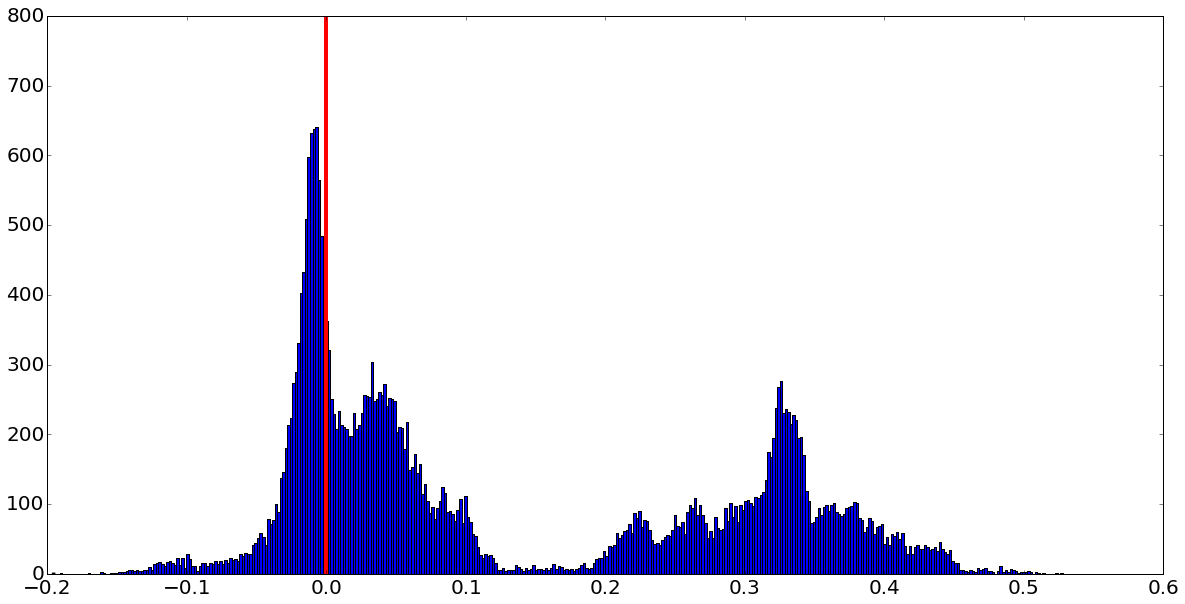

In [195]:
fig = plt.figure(figsize=(20,10))
hist = plt.hist(res_list[11].fittedvalues, bins = 400)
plt.vlines(0,0,800, color = 'r',linewidth = 4 )

In [196]:
info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100),'pseudo-R2':lambda x:"{:4.2f}%".format(x.prsquared*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,float_format='%.3f')


                                     DNO_all I DNO_all II DNO_all III DNO_all IIII   DNO I     DNO II   DNO III   DNO IIII DNO_1_prct I DNO_1_prct II DNO_1_prct III DNO_1_prct IIII DNO_05_prct I DNO_05_prct II DNO_05_prct III DNO_05_prct IIII
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
I(Rni / 100000)                      0.089***  0.038***   0.091***    0.039***     0.199***  0.121***  0.092***  0.058***  0.041***     -0.188***     -0.021         -0.123***       -0.023**      -0.201***      -0.069***       -0.155***       
                                     (0.008)   (0.008)    (0.008)     (0.008)      (0.014)   (0.014)   (0.015)   (0.015)   (0.014)      (0.013)       (0.015)        (0.014)         (0.011)       (0.010)        (0.013)         (0.011)         
Gain_fiscal_au_pacs[T.True]

In [197]:
regressor_order=["Intercept","I(Rni / 100000)" ,"I(Age_moyen_parents / 100)",
                 "Age_x1_child", 
                 "Children_number_is_2[T.True]", "Age_younger_x2_child" , "Age_elder_x2_child", 
                 "Children_number_is_3[T.True]", "Age_younger_x3_child" , "Age_elder_x3_child", 
                 "Children_number_is_4_or_more[T.True]", "Age_younger_x4_or_more_child" , "Age_elder_x4_or_more_child", 
                "Same_diploma_Master[T.True]","Same_diploma_licence[T.True]", "Same_diploma_No_educ[T.True]","Same_diploma_Vocational[T.True]",
                 "Licence_education_femme[T.True]","Licence_education_homme[T.True]",
                 "Vocational_education_femme[T.True]","Vocational_education_homme[T.True]",
                 "Master_PhD_education_femme[T.True]", "Master_PhD_education_homme[T.True]",
                 "TC",
                 "year_2014[T.True]",
                 
                ]

#### With diplomas

In [198]:
#threshold_DNO_dict = OrderedDict([(("DNO_all", df2013_A),10**-25),(("DNO", df2013_B),10**-25),  (("DNO_1prct",df2013_A.query("Can_optimize_to_1_prct") ), 10**-2), (("DNO_05prct", df2013_A.query("Can_optimize_to_0_5_prct")), 0.005)])
threshold_DNO_dict = OrderedDict([("DNO_all", (10**-25, df2013_A)), ("DNO",(10**-25,df2013_A.query("Can_optimize") ))])#("DNO_1prct", 10**-2), ("DNO_05prct", 0.005)])
threshold_DNO_dict = OrderedDict([("DNO_all", (10**-25, df2013_A)), ("DNO",(10**-25,df2013_A.query("Can_optimize") )),  
                                  ("DNO_1_prct",(10**-2,df2013_A.query("Can_optimize_to_1_prct") )),  ("DNO_05_prct",(10**-2,df2013_A.query("Can_optimize_to_0_5_prct") ))])
print "Do not optimize"
res_list = list()
for thrshld_name, thrshld_tuple in threshold_DNO_dict.iteritems():
    thrshld_value = thrshld_tuple[0]
    df_temp = thrshld_tuple[1]
    df_temp["Second_best_DNO"] = df_temp.Two_smallest_allocation_difference < (df_temp.Rni/thrshld_value) * (~df_temp.Children_number_is_1)
    for var_reg in [var_reg_household, var_reg_income_tax, var_reg_income_tax2 , var_reg_income_tax3]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
        df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg+"+"+"+".join(diploma_4_categories_to_regress)+"+Same_diploma",
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Do not optimize


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [199]:
info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100),'pseudo-R2':lambda x:"{:4.2f}%".format(x.prsquared*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,float_format='%.3f')


                                     DNO_all I DNO_all II DNO_all III DNO_all IIII   DNO I     DNO II   DNO III   DNO IIII DNO_1_prct I DNO_1_prct II DNO_1_prct III DNO_1_prct IIII DNO_05_prct I DNO_05_prct II DNO_05_prct III DNO_05_prct IIII
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                            -0.024    -0.008     -0.023      -0.004       -0.004    0.007     0.029     0.028     -0.006       0.024         0.005          0.000           0.001         0.025*         0.008           0.007           
                                     (0.018)   (0.017)    (0.018)     (0.017)      (0.020)   (0.020)   (0.020)   (0.020)   (0.018)      (0.016)       (0.018)        (0.016)         (0.016)       (0.014)        (0.016)         (0.014)         
I(Rni / 100000)            

In [200]:
#threshold_DNO_dict = OrderedDict([(("DNO_all", df2013_A),10**-25),(("DNO", df2013_B),10**-25),  (("DNO_1prct",df2013_A.query("Can_optimize_to_1_prct") ), 10**-2), (("DNO_05prct", df2013_A.query("Can_optimize_to_0_5_prct")), 0.005)])
threshold_DNO_dict = OrderedDict([("DNO_all", (10**-25, df2013_A)), ("DNO",(10**-25,df2013_A.query("Can_optimize") ))])#("DNO_1prct", 10**-2), ("DNO_05prct", 0.005)])
threshold_DNO_dict = OrderedDict([("DNO_all", (10**-25, df2013_A)), ("DNO",(10**-25,df2013_A.query("Can_optimize") )),  
                                  ("DNO_1_prct",(10**-2,df2013_A.query("Can_optimize_to_1_prct") )),  ("DNO_05_prct",(10**-2,df2013_A.query("Can_optimize_to_0_5_prct") ))])
print "Do not optimize"
res_list = list()
for thrshld_name, thrshld_tuple in threshold_DNO_dict.iteritems():
    thrshld_value = thrshld_tuple[0]
    df_temp = thrshld_tuple[1]
    df_temp["Second_best_DNO"] = df_temp.Two_smallest_allocation_difference < (df_temp.Rni/thrshld_value) * (~df_temp.Children_number_is_1)
    for var_reg in [var_reg_household, var_reg_income_tax, var_reg_income_tax2 , var_reg_income_tax3]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
        df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg+"+Same_diploma_No_educ+Same_diploma_Vocational+Same_diploma_licence+Same_diploma_Master",
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Do not optimize


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [201]:
info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100),'pseudo-R2':lambda x:"{:4.2f}%".format(x.prsquared*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,float_format='%.3f')


                                     DNO_all I DNO_all II DNO_all III DNO_all IIII   DNO I     DNO II   DNO III   DNO IIII DNO_1_prct I DNO_1_prct II DNO_1_prct III DNO_1_prct IIII DNO_05_prct I DNO_05_prct II DNO_05_prct III DNO_05_prct IIII
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                            0.062***  0.080***   0.063***    0.081***     0.069***  0.088***  0.105***  0.110***  0.019        0.057***      0.030*         0.030**         0.023         0.056***       0.031**         0.037***        
                                     (0.017)   (0.016)    (0.017)     (0.016)      (0.018)   (0.018)   (0.019)   (0.018)   (0.016)      (0.015)       (0.017)        (0.015)         (0.014)       (0.013)        (0.014)         (0.013)         
I(Rni / 100000)            

In [202]:
df2013_A_diplomas.Same_diploma.value_counts(normalize = True)

True    0.524
False   0.476
dtype: float64

In [203]:
print df2013_A_diplomas.query("No_education_femme").Same_diploma_No_educ.value_counts(normalize = True)
print df2013_A_diplomas.query("Vocational_education_femme").Same_diploma_Vocational.value_counts(normalize = True)
print df2013_A_diplomas.query("Licence_education_femme").Same_diploma_licence.value_counts(normalize = True)
print df2013_A_diplomas.query("Master_PhD_education_femme").Same_diploma_Master.value_counts(normalize = True)

False   0.655
True    0.345
dtype: float64
True    0.718
False   0.282
dtype: float64
False   0.758
True    0.242
dtype: float64
False   0.646
True    0.354
dtype: float64


In [204]:
print df2013_A_diplomas.query("No_education_homme").Same_diploma_No_educ.value_counts(normalize = True)
print df2013_A_diplomas.query("Vocational_education_homme").Same_diploma_Vocational.value_counts(normalize = True)
print df2013_A_diplomas.query("Licence_education_homme").Same_diploma_licence.value_counts(normalize = True)
print df2013_A_diplomas.query("Master_PhD_education_homme").Same_diploma_Master.value_counts(normalize = True)

False   0.781
True    0.219
dtype: float64
True    0.621
False   0.379
dtype: float64
False   0.604
True    0.396
dtype: float64
True    0.548
False   0.452
dtype: float64


In [205]:
educ = ["No_education_femme", "Vocational_education_femme", "Licence_education_femme", "Master_PhD_education_femme", "No_education_homme", "Vocational_education_homme", "Licence_education_homme", "Master_PhD_education_homme"]
educ_femme = ["No_education_femme", "Vocational_education_femme", "Licence_education_femme", "Master_PhD_education_femme",]
educ_homme = [ "No_education_homme", "Vocational_education_homme", "Licence_education_homme", "Master_PhD_education_homme"]

In [206]:
for var in educ_femme:
    df2013_A_diplomas.loc[df2013_A_diplomas[var] ,"Diplome_femme_str"] = var
for var in educ_homme:
    df2013_A_diplomas.loc[df2013_A_diplomas[var] ,"Diplome_homme_str"] = var

In [207]:
cross_tab = pd.crosstab(df2013_A_diplomas["Diplome_femme_str"], df2013_A_diplomas["Diplome_homme_str"], margins=True)
cross_tab_2 = cross_tab/df2013_A_diplomas.shape[0]

In [208]:
cross_tab_2.loc[:, 'All'] = cross_tab.loc[:, "All"]/len(df2013_A)

In [209]:
cross_tab_2.loc[:, 'All']/cross_tab.loc[:, "All"]

Diplome_femme_str
Licence_education_femme      0.000
Master_PhD_education_femme   0.000
No_education_femme           0.000
Vocational_education_femme   0.000
All                          0.000
Name: All, dtype: float64

In [210]:
cross_tab

Diplome_homme_str,Licence_education_homme,Master_PhD_education_homme,No_education_homme,Vocational_education_homme,All
Diplome_femme_str,,,,,
Licence_education_femme,1782,752,665,4178,7377
Master_PhD_education_femme,1020,1599,243,1656,4518
No_education_femme,135,41,1040,1800,3016
Vocational_education_femme,1562,524,2809,12486,17381
All,4499,2916,4757,20120,32292


In [211]:
cross_tab_2

Diplome_homme_str,Licence_education_homme,Master_PhD_education_homme,No_education_homme,Vocational_education_homme,All
Diplome_femme_str,,,,,
Licence_education_femme,0.055,0.023,0.021,0.129,0.144
Master_PhD_education_femme,0.032,0.050,0.008,0.051,0.088
No_education_femme,0.004,0.001,0.032,0.056,0.059
Vocational_education_femme,0.048,0.016,0.087,0.387,0.340
All,0.139,0.090,0.147,0.623,0.631


### Groupe B both year 

In [212]:
df2013_A["Montant_Gain_fiscal_au_pacs_effective"] = df2013_A.Gain_fiscal_au_pacs
df2013_A["Montant_Gain_fiscal_au_pacs_potentiel"] = df2013_A.result_min_allocation - df2013_A.Irpp_decote_pacs
df2013_A["Montant_Gain_fiscal_au_pacs"] = df2013_A.result_min_allocation - df2013_A.Irpp_decote_pacs
df2013_A["Gain_fiscal_au_pacs"] = df2013_A["Montant_Gain_fiscal_au_pacs"]> 0 
df2013_A["Perte_fiscale_au_pacs"] = df2013_A["Montant_Gain_fiscal_au_pacs"]< 0 

In [213]:
df2013_A["Gain_fiscal_au_pacs"] = df2013_A["Montant_Gain_fiscal_au_pacs"]> 0 

(-600, 1000)

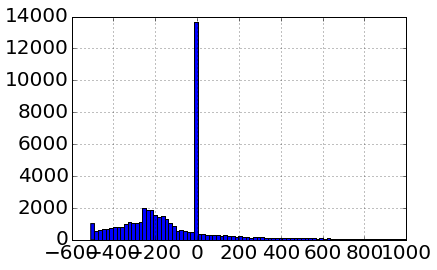

In [214]:
df2013_A.Montant_Gain_fiscal_au_pacs.hist(bins = 1000)
plt.xlim(-600,1000)

In [215]:
seuil_1 = 0.0000000000000000000000000000000000000000000000000000000001
print "Do not optimize"
res_list = list()
for var_reg in [var_reg_0,var_reg_01]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)
for var_reg in [var_reg_1, var_reg_2,var_reg_02]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)

        
        
seuil_1 = 0.01
print "Do not optimize 1 %"

for var_reg in [var_reg_0,var_reg_01]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO_1_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO_1_prct~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)
for var_reg in [var_reg_1, var_reg_2,var_reg_02]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO_1_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO_1_prct~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)
        
seuil_1 = 0.005
print "Do not optimize 0.5 %"

for var_reg in [var_reg_0,var_reg_01]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO_05_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO_05_prct~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)
for var_reg in [var_reg_1, var_reg_2, var_reg_02]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO_05_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO_05_prct~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)

Do not optimize
Do not optimize 1 %
Do not optimize 0.5 %


In [216]:
regressor_order=["Age_moyen","Ecart_Age_en_valeur_absolue","I(Rni / 100000)" ,
                 "Age_elder_child","Age_younger_child",
                 "deux_enfants[T.True]", "trois_enfants[T.True]", "quatre_enfants_et_plus[T.True]",
                "Same_diploma_Master[T.True]","Same_diploma_licence[T.True]", "Same_diploma_No_educ[T.True]","Same_diploma_Vocational[T.True]",
                 "Licence_education_femme[T.True]","Licence_education_homme[T.True]",
                 "Vocational_education_femme[T.True]","Vocational_education_homme[T.True]",
                 "Master_PhD_education_femme[T.True]", "Master_PhD_education_homme[T.True]",
                 "TC",
                 "year_2014[T.True]", "Intercept"
                 
                ]

In [217]:
OLS.rsquared_adj

0.0170139389206726

In [218]:
info_dict={'rsquared_adj':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,)


                                     DNO I      DNO II    DNO III    DNO IIII  DNO IIIII  DNO_1_prct I DNO_1_prct II DNO_1_prct III DNO_1_prct IIII DNO_1_prct IIIII DNO_05_prct I DNO_05_prct II DNO_05_prct III DNO_05_prct IIII DNO_05_prct IIIII
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_moyen                          0.0059***  0.0034***  0.0045***  0.0037***  0.0043***  0.0015***    0.0016***     0.0017***      0.0016***       0.0016***        0.0023***     0.0017***      0.0021***       0.0020***        0.0020***        
                                   (0.0004)   (0.0004)   (0.0006)   (0.0006)   (0.0006)   (0.0003)     (0.0003)      (0.0004)       (0.0004)        (0.0004)         (0.0003)      (0.0003)       (0.0004)        (0.0005)         (0.0005)         
Ecart_Age_en_valeur

In [219]:
info_dict={'rsquared_adj':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,)


                                     DNO I      DNO II    DNO III    DNO IIII  DNO IIIII  DNO_1_prct I DNO_1_prct II DNO_1_prct III DNO_1_prct IIII DNO_1_prct IIIII DNO_05_prct I DNO_05_prct II DNO_05_prct III DNO_05_prct IIII DNO_05_prct IIIII
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_moyen                          0.0059***  0.0034***  0.0045***  0.0037***  0.0043***  0.0015***    0.0016***     0.0017***      0.0016***       0.0016***        0.0023***     0.0017***      0.0021***       0.0020***        0.0020***        
                                   (0.0004)   (0.0004)   (0.0006)   (0.0006)   (0.0006)   (0.0003)     (0.0003)      (0.0004)       (0.0004)        (0.0004)         (0.0003)      (0.0003)       (0.0004)        (0.0005)         (0.0005)         
Ecart_Age_en_valeur

In [220]:
info_dict={'adj-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,)


                                     DNO I      DNO II    DNO III    DNO IIII  DNO IIIII  DNO_1_prct I DNO_1_prct II DNO_1_prct III DNO_1_prct IIII DNO_1_prct IIIII DNO_05_prct I DNO_05_prct II DNO_05_prct III DNO_05_prct IIII DNO_05_prct IIIII
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_moyen                          0.0059***  0.0034***  0.0045***  0.0037***  0.0043***  0.0015***    0.0016***     0.0017***      0.0016***       0.0016***        0.0023***     0.0017***      0.0021***       0.0020***        0.0020***        
                                   (0.0004)   (0.0004)   (0.0006)   (0.0006)   (0.0006)   (0.0003)     (0.0003)      (0.0004)       (0.0004)        (0.0004)         (0.0003)      (0.0003)       (0.0004)        (0.0005)         (0.0005)         
Ecart_Age_en_valeur

### Both year but present both year (pour ajouter la naissance de l'enfant comme variable)

In [221]:
child_gain_id_fisc_log_diff = df_A[df_A.Family_child_gain].ID_FISC_LOG_DIFF
observed_both_years_id_fisc_log_diff = df_A.ID_FISC_LOG_DIFF

In [222]:
for df_temp in [df2013_A, df2014_A, df2013_B, df2014_B]:
    df_temp["Family_child_gain"] = df_temp.ID_FISC_LOG_DIFF.isin(child_gain_id_fisc_log_diff)
    df_temp["Observed_both_years"] = df_temp.ID_FISC_LOG_DIFF.isin(observed_both_years_id_fisc_log_diff)

In [223]:
seuil_1 = 0.0000000000000000000000000000000000000000000000000000000001
print "Do not optimize"
res_list = list()
for var_reg in [var_reg_0 +"+Family_child_gain",var_reg_01+"+Family_child_gain"]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp = df_temp[df_temp["Observed_both_years"]]
        df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)
for var_reg in [var_reg_1+"+Family_child_gain", var_reg_2+"+Family_child_gain",var_reg_02+"+Family_child_gain"]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp = df_temp[df_temp["Observed_both_years"]]
        df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)

        
        
seuil_1 = 0.01
print "Do not optimize 1 %"

for var_reg in [var_reg_0+"+Family_child_gain",var_reg_01+"+Family_child_gain"]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO_1_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp = df_temp[df_temp["Observed_both_years"]]
        df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO_1_prct~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)
for var_reg in [var_reg_1+"+Family_child_gain", var_reg_2+"+Family_child_gain",var_reg_02+"+Family_child_gain"]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO_1_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp = df_temp[df_temp["Observed_both_years"]]
        df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO_1_prct~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)
        
seuil_1 = 0.005
print "Do not optimize 0.5 %"

for var_reg in [var_reg_0+"+Family_child_gain",var_reg_01+"+Family_child_gain"]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO_05_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp = df_temp[df_temp["Observed_both_years"]]
        df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO_05_prct~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)
for var_reg in [var_reg_1+"+Family_child_gain", var_reg_2+"+Family_child_gain", var_reg_02+"+Family_child_gain"]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO_05_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp = df_temp[df_temp["Observed_both_years"]]
        df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO_05_prct~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)

Do not optimize
Do not optimize 1 %
Do not optimize 0.5 %


In [224]:
info_dict={'adj-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100),"Log_likelihood":lambda x:"{:d}".format(int(x.llf)), "N":lambda x:"{:d}".format(int(x.nobs))}
print "2013_B"
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,)

2013_B

                                     DNO I      DNO II    DNO III    DNO IIII  DNO IIIII  DNO_1_prct I DNO_1_prct II DNO_1_prct III DNO_1_prct IIII DNO_1_prct IIIII DNO_05_prct I DNO_05_prct II DNO_05_prct III DNO_05_prct IIII DNO_05_prct IIIII
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_moyen                          0.0055***  0.0032***  0.0047***  0.0038***  0.0044***  0.0013***    0.0016***     0.0018***      0.0017***       0.0017***        0.0020***     0.0016***      0.0024***       0.0022***        0.0022***        
                                   (0.0005)   (0.0005)   (0.0007)   (0.0007)   (0.0007)   (0.0003)     (0.0003)      (0.0004)       (0.0004)        (0.0004)         (0.0004)      (0.0004)       (0.0005)        (0.0005)         (0.0005)         
Ecart_Age_en

### groupe B 2013

In [225]:
#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+


var_reg_0 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus"
        )
var_reg_1 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus+"
            "+Same_diploma_No_educ+Same_diploma_Vocational+Same_diploma_licence+Same_diploma_Master"
        )
var_reg_2 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus"+"+"+"+".join(diploma_4_categories_to_regress))

In [226]:
for df_select in [df2013_A, df2014_A, df2013_B, df2014_B]:
    seuil_1 = 0.0000000000000000000000000000000000000000000000000000000001
    print "Do not optimize"
    res_list = list()
    for var_reg in [var_reg_0]:
        for df_temp in [df_select]:# [df_concat_A, df_concat_C]:
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
            df_temp["DNO"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "DNO~"+var_reg,
                             data = df_temp2).fit() #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
    for var_reg in [var_reg_1, var_reg_2]:
        for df_temp.Ag in [df_select]:# [df_concat_A, df_concat_C]:
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
            df_temp["DNO"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "DNO~"+var_reg,
                             data = df_temp2).fit() #Ordre olivier, virer "No_decote"
            res_list.append(OLS)



    seuil_1 = 0.01
    print "Do not optimize 1 %"

    for var_reg in [var_reg_0]:
        for df_temp in [df_select]:# [df_concat_A, df_concat_C]:
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
            df_temp["DNO_1_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "DNO_1_prct~"+var_reg,
                             data = df_temp2).fit() #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
    for var_reg in [var_reg_1, var_reg_2]:
        for df_temp in [df_select]:# [df_concat_A, df_concat_C]:
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
            df_temp["DNO_1_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "DNO_1_prct~"+var_reg,
                             data = df_temp2).fit() #Ordre olivier, virer "No_decote"
            res_list.append(OLS)

    seuil_1 = 0.005
    print "Do not optimize 0.5 %"

    for var_reg in [var_reg_0]:
        for df_temp in [df_select]:# [df_concat_A, df_concat_C]:
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
            df_temp["DNO_05_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "DNO_05_prct~"+var_reg,
                             data = df_temp2).fit() #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
    for var_reg in [var_reg_1, var_reg_2]:
        for df_temp in [df_select]:# [df_concat_A, df_concat_C]:
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
            df_temp["DNO_05_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "DNO_05_prct~"+var_reg,
                             data = df_temp2).fit() #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
    info_dict={'adj-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100),"Log_likelihood":lambda x:"{:d}".format(int(x.llf)), "N":lambda x:"{:d}".format(int(x.nobs))}
    print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,)

Do not optimize
Do not optimize 1 %
Do not optimize 0.5 %

                                     DNO I      DNO II    DNO III   DNO_1_prct I DNO_1_prct II DNO_1_prct III DNO_05_prct I DNO_05_prct II DNO_05_prct III
----------------------------------------------------------------------------------------------------------------------------------------------------------
Age_moyen                          0.0059***  0.0045***  0.0037***  0.0015***    0.0017***     0.0016***      0.0023***     0.0021***      0.0020***      
                                   (0.0005)   (0.0006)   (0.0006)   (0.0003)     (0.0004)      (0.0004)       (0.0004)      (0.0004)       (0.0005)       
Ecart_Age_en_valeur_absolue        -0.0046*** -0.0035*** -0.0028*** -0.0004      -0.0003       -0.0002        -0.0009       -0.0005        -0.0004        
                                   (0.0007)   (0.0008)   (0.0008)   (0.0005)     (0.0005)      (0.0005)       (0.0006)      (0.0006)       (0.0006)       
I(Rni / 100

### Autres marges que le % de revenu

In [227]:
for dependent_var in ["Fiscal_loss","Prct_rev_perte_fiscale" ]:
    print dependent_var
    for df_select in [ df2013_B, df2014_B]:
        res_list = list()
        for var_reg in [var_reg_0]:
            for df_temp in [df_select]:# [df_concat_A, df_concat_C]:
                df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
                df_temp["DNO"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
                df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
                df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
                OLS = smf.OLS.from_formula(formula =  "{}~".format(dependent_var)+var_reg,
                                 data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
                res_list.append(OLS)
        for var_reg in [var_reg_1, var_reg_2]:
            for df_temp.Ag in [df_select]:# [df_concat_A, df_concat_C]:
                df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
                df_temp["DNO"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
                df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
                df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
                OLS = smf.OLS.from_formula(formula =   "{}~".format(dependent_var)+var_reg,
                                 data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
                res_list.append(OLS)


Fiscal_loss
Prct_rev_perte_fiscale


In [228]:
info_dict={'adj-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,)


                                   Prct_rev_perte_fiscale I Prct_rev_perte_fiscale II Prct_rev_perte_fiscale III
----------------------------------------------------------------------------------------------------------------
Age_moyen                          0.0001***                0.0001**                  0.0001**                  
                                   (0.0000)                 (0.0001)                  (0.0001)                  
Ecart_Age_en_valeur_absolue        -0.0001*                 -0.0001*                  -0.0001*                  
                                   (0.0001)                 (0.0001)                  (0.0001)                  
I(Rni / 100000)                    0.0015                   0.0025                    0.0026                    
                                   (0.0012)                 (0.0016)                  (0.0016)                  
Age_elder_child                    -0.0004***               -0.0004***                -0.0004**

In [229]:
seuil_1 = 0.000000000000000000001
print "Do optimize"
for df_temp in [df_concat_B]:# [df_concat_A, df_concat_C]:
    df_temp["Perte_fiscale_less_then_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
    df_temp["Perte_fiscale_less_then"] = df_temp["Perte_fiscale_less_then_{}_prct_rev".format(seuil_1)].astype('int')
    print df_temp.shape
    df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
    df_temp2 = df_temp#df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
    PROBIT = smf.Probit.from_formula(formula =  "Perte_fiscale_less_then~"+ "Age_younger_child+Age_elder_child+"+
                     "Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+"+
                     "deux_enfants+trois_enfants+ quatre_enfants_et_plus+year_2014+"+#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
                    "+"+"+".join(diploma_4_categories_to_regress),
                                    # "+Same_diploma_No_educ+Same_diploma_Vocational+Same_diploma_licence+Same_diploma_Master",
                     data = df_temp2).fit() #Ordre olivier, virer "No_decote"
print PROBIT.summary()



seuil_1 = 0.000000000000000000001

for df_temp in [df_concat_B]:# [df_concat_A, df_concat_C]:
    df_temp["Perte_fiscale_less_then_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
    df_temp["Perte_fiscale_less_then"] = df_temp["Perte_fiscale_less_then_{}_prct_rev".format(seuil_1)].astype('int')
    print df_temp.shape
    df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
    df_temp2 = df_temp#df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
    PROBIT = smf.Probit.from_formula(formula =  "Perte_fiscale_less_then~"+ "Age_younger_child+Age_elder_child+"+
                     "Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+"+
                     "deux_enfants+trois_enfants+ quatre_enfants_et_plus+year_2014+"+#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
                    #"+"+"+".join(diploma_4_categories_to_regress),
                                     "+Same_diploma_No_educ+Same_diploma_Vocational+Same_diploma_licence+Same_diploma_Master",
                     data = df_temp2).fit() #Ordre olivier, virer "No_decote"

print PROBIT.summary()

Do optimize
(90230, 230)
Optimization terminated successfully.
         Current function value: 0.573082
         Iterations 5
                             Probit Regression Results                             
Dep. Variable:     Perte_fiscale_less_then   No. Observations:                56722
Model:                              Probit   Df Residuals:                    56705
Method:                                MLE   Df Model:                           16
Date:                     Mon, 29 Oct 2018   Pseudo R-squ.:                 0.02270
Time:                             17:47:01   Log-Likelihood:                -32506.
converged:                            True   LL-Null:                       -33261.
                                             LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------

In [230]:
seuil_1 = 0.01


for df_temp in [df2013_B]:# [df_concat_A, df_concat_C]:
    df_temp["Perte_fiscale_less_then_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)<seuil_1
    df_temp["Perte_fiscale_less_then"] = df_temp["Perte_fiscale_less_then_{}_prct_rev".format(seuil_1)].astype('int')
    print df_temp.shape
    df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
    df_temp2 = df_temp#df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
    PROBIT = smf.Probit.from_formula(formula =  "Perte_fiscale_less_then~"+ 
                     #"Age_moyen + Age_moyen_squared+Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+"+
                     #"Diff_in_incompe_mere_pere+deux_enfants+trois_enfants_et_plus+"+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    "Gain_fiscal_au_pacs",
                    #"+"+"+".join(diploma_4_categories_to_regress)+ "+Same_diploma_No_educ+Same_diploma_Vocational+Same_diploma_licence+Same_diploma_Master",
                     data = df_temp2).fit() #Ordre olivier, virer "No_decote"
print PROBIT.summary()

(45411, 268)
Optimization terminated successfully.
         Current function value: 0.215890
         Iterations 8
                             Probit Regression Results                             
Dep. Variable:     Perte_fiscale_less_then   No. Observations:                45411
Model:                              Probit   Df Residuals:                    45409
Method:                                MLE   Df Model:                            1
Date:                     Mon, 29 Oct 2018   Pseudo R-squ.:                  0.3020
Time:                             17:47:01   Log-Likelihood:                -9803.8
converged:                            True   LL-Null:                       -14046.
                                             LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept            

In [231]:
stop_time = datetime.datetime.now(); print("now: ",stop_time);
execution_time = stop_time - start_time; print("execution_time: ",execution_time)
stop_time = start_time

('now: ', datetime.datetime(2018, 10, 29, 17, 47, 1, 748000))
('execution_time: ', datetime.timedelta(0, 786, 656000))


In [232]:
for col in df_temp2.columns:
    print col

ID_FISC_LOG_DIFF
level_0
ANAIS
AN_FISC_x
AN_FISC_y
Age
Age_mere
Age_pere
Allocation_mere
Allocation_pere
CNE1
COM_NSCAT
COM_SCAT1
COM_SCAT2
DACOED
DACOEP
Decote
Decote_pacs
Fiscal_loss
Gain_fiscal_max
Gain_fiscal_max_in_ratio
ID_DIFF
ID_FISC_FOY_DIFF
I_FISC_LOGEMENT
I_FISC_REVENU
Irpp_ac_plaf_qf
Irpp_ac_plaf_qf_mere
Irpp_ac_plaf_qf_pacs
Irpp_ac_plaf_qf_pere
Irpp_ac_qf
Irpp_ac_qf_pacs
Irpp_decote
Irpp_decote_allocation_1
Irpp_decote_allocation_2
Irpp_decote_allocation_3
Irpp_decote_allocation_4
Irpp_decote_allocation_5
Irpp_decote_allocation_6
Irpp_decote_allocation_7
Irpp_decote_allocation_8
Irpp_decote_allocation_9
Irpp_decote_mere
Irpp_decote_pacs
Irpp_decote_pere
Irpp_decote_seuil_prel_allocation_1
Irpp_decote_seuil_prel_allocation_2
Irpp_decote_seuil_prel_allocation_3
Irpp_decote_seuil_prel_allocation_4
Irpp_decote_seuil_prel_allocation_5
Irpp_decote_seuil_prel_allocation_6
Irpp_decote_seuil_prel_allocation_7
Irpp_decote_seuil_prel_allocation_8
Irpp_decote_seuil_prel_allocation_9
I